### Jupyter for making figure for fastDMF+plastic FIC
#### I.- Inhibitory homeostatic plasticity rule enhances model stability and plausibility
    
    1.- Decay vs Learning rate relationship for different objective firing rates    
    2.- Firing Rate comparison between static vs dynamic FIC    
    3.- Convergence of dynamic FIC to the linear solution
    4.- Comparison of firing rate under neuromodulation


#### II.- Fitting to fMRI

    1.- Objective function for static and dynamics FIC for FC    
    2.- Violin plot of the fit to FC at the optimum    
    3.- Objective function for static and dynamics FIC for FCD    
    4.- Violin plot of the fit to FCD at the optimum


#### III.- A potential mechanism for whole-brain slow-waves
    1.- G vs LR Parameter space with autocorrelation peak
    2.- G vs LR Parameter space with autocorrelation time to peak
    3.- Average firing rate trace at slow wave region
    4.- Average firing rate trace at no-slow wave region (best fit to wake data)

In [1]:
# ! pip install mat73

In [2]:
import os
import time
import seaborn as sns
import numpy as np
import pandas as pd
# import fastdyn_fic_dmf as dmf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from scipy import stats
import mat73
from scipy.stats import pearsonr
from scipy.spatial.distance import cdist
from matplotlib.gridspec import GridSpec


### I.- Inhibitory homeostatic plasticity rule enhances model stability and plausibility

In [3]:
# Loading data
# datafolder = 'C:/Users/rherz/OneDrive/Documents/Projects/dynFIC/data2plot/'
# figfold = 'C:/Users/rherz/OneDrive/Documents/Projects/dynFIC/paper_fig/paper_figs/figures/'
#datafolder = '/home/ruben.herzog/OneDrive/Projects/dynFIC/data2plot/'
#figfold = '/home/ruben.herzog/OneDrive/Projects/dynFIC/paper_figs/figures/'
datafolder = '/home/ivan.mindlin/Desktop/DatosParaRuben/'
figfold = '/home/ivan.mindlin/Repos/dyn_fic_dmf/paper_figs/'
# Homeostatic fit
hom_fit_list = [] # 0=1.22, 1=3.44, 2=6.88, 3=50
hom_fit_list.append(np.load(datafolder+'ChequeoPreliminar/HomeostaticFit1-22-Grid/hom_grid.npy'))
hom_fit_list.append(np.load(datafolder+'ChequeoPreliminar/HomeostaticFit3-44-Grid/hom_grid.npy'))
hom_fit_list.append(np.load(datafolder+'ChequeoPreliminar/HomeostaticFit6-88-Grid/hom_grid.npy'))
hom_fit_list.append(np.load(datafolder+'ChequeoPreliminar/HomeostaticFit50-Grid/hom_grid.npy'))

fic_corr = np.load(datafolder+'ChequeoPreliminar/fic_cor_timeseries_grid.npy')

# Static vs Dynamic FIC comparison
all_rates_stat = np.load(datafolder+'ChequeoPreliminar/avg_fr_stat_values.npy')
all_rates_dyn = np.load(datafolder+'ChequeoPreliminar/avg_fr_dyn_values.npy')
fic_t = np.load(datafolder+'ChequeoPreliminar/dyn_fic_values.npy')
static_fic = np.load(datafolder+'ChequeoPreliminar/stat_fic_values.npy')

# Neuromodulation
nm_mean_fr = [] # 0 is static, 1 dynamic
nm_std_fr = [] # 0 is static, 1 dynamic
nm_fc = [] # 0 is static, 1 dynamic
nm_fcd = [] # 0 is static, 1 dynamic
nm_mean_fr.append(np.load(datafolder+'neuromod/staticD2/mean_fr_grid.npy'))
nm_mean_fr.append(np.load(datafolder+'neuromod/dynamicD2/mean_fr_grid.npy'))
nm_std_fr.append(np.load(datafolder+'neuromod/staticD2/std_fr_grid.npy'))
nm_std_fr.append(np.load(datafolder+'neuromod/dynamicD2/std_fr_grid.npy'))
# nm_fc.append(np.load(datafolder+'neuromod/static/mean_fc_grid.npy'))
# nm_fc.append(np.load(datafolder+'neuromod/dynamic/mean_fc_grid.npy'))
# nm_fcd.append(np.load(datafolder+'neuromod/static/sim_stds_grid.npy'))
# nm_fcd.append(np.load(datafolder+'neuromod/dynamic/sim_stds_grid.npy'))

# Slow waves
peak_val_ac_grid = np.load(datafolder+'slow_waves/peak_autocorrelation_grid.npy')
peak_time_ac_grid = np.load(datafolder+'slow_waves/peak_time_grid.npy')
corr_to_sc_grid = np.load(datafolder+'slow_waves/corr_to_sc_grid.npy')
rates_grid = np.load(datafolder+'slow_waves/rates_grid.npy')
homeo_fit_grid = np.load(datafolder+'slow_waves/homeostatic_fittness_grid.npy')

# Font sizes
TITLE = 18
LABEL = 14
TICKS = 12
LEGEND = 12
COLORBAR = 14


#### Homeostatic Fit

In [4]:
# HOMEOSTATIC FIT
# Extracting averages over the range of G
G_range = np.arange(0,8.5, 0.5)
LR_range = np.logspace(0,3,100)
DECAY_range = np.logspace(2,6,110)
obj_rates = [1.22, 3.44, 6.88, 50]

nobjs = len(obj_rates)
ngs = len(G_range)
nlr = len(LR_range)
ndec = len(DECAY_range)
lr_labels = [1, 10, 100, 1000]
dec_labels = [100, 1000, 10000, 100000]

# Mean and average over G
mean_hom_fit = [np.mean(x,axis=2) for x in hom_fit_list]
std_hom_fit = [np.std(x,axis=2) for x in hom_fit_list]

# Extracting Minimum mismatch
min_mm_pos = [np.argmin(np.abs(x),axis=0) for x in mean_hom_fit]

# Fitting linear trend
fit_res = list()
fit_res_2plot = list()
for o in range(nobjs):
    if o==0:
        fit_res.append(np.polyfit(LR_range[21:], min_mm_pos[o][21:], 1))
        fit_res_2plot.append(np.polyfit(range(0,nlr)[21:], min_mm_pos[o][21:], 1))
    else:
        fit_res.append(np.polyfit(LR_range, min_mm_pos[o], 1))
        fit_res_2plot.append(np.polyfit(range(0,nlr), min_mm_pos[o], 1))    
    


### Acá falta el plot con la correlación del promedio del FIC vs la fuerza de conectividad

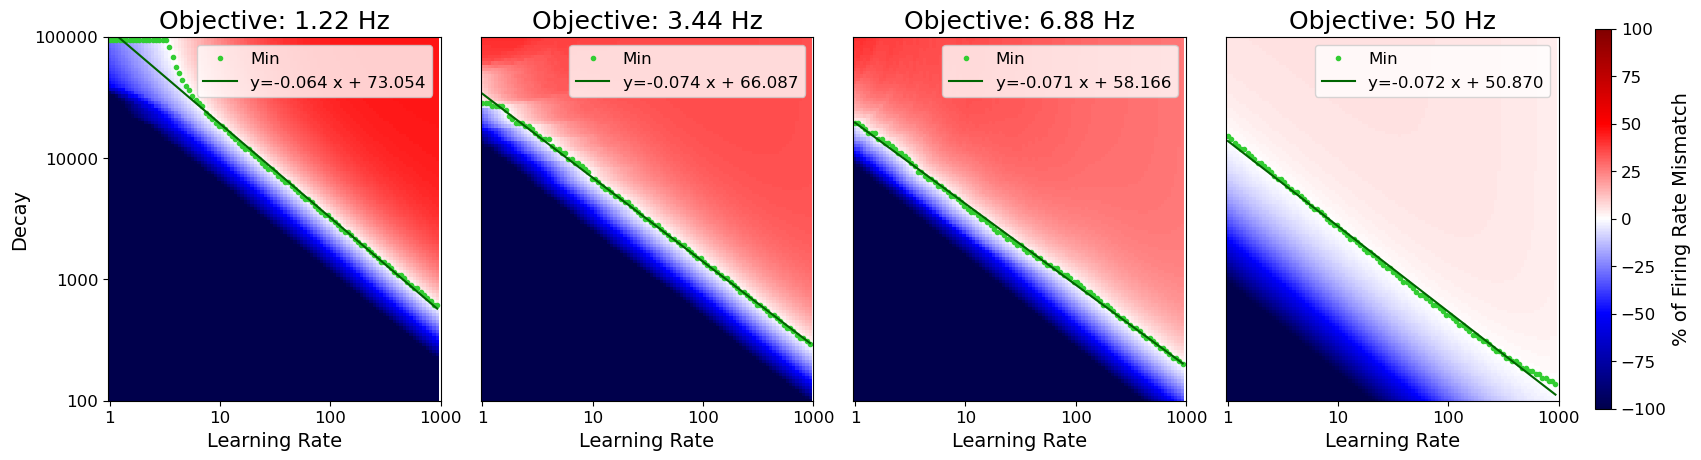

In [5]:


# Plotting Average over G
figname = 'FIG_2_A'
fig = plt.figure(figsize=(16, 10))

for o in range(nobjs):
    # Average over G
    ax = plt.subplot(1, nobjs, o + 1)
    plt.imshow(100 * mean_hom_fit[o] / obj_rates[o], vmin=-100, vmax=100, cmap='seismic', 
               origin='lower', interpolation='none')
    plt.plot(range(0, nlr), min_mm_pos[o], '.', label='Min', color='limegreen')
    plt.plot(range(0, nlr), fit_res_2plot[o][0] * range(0, nlr) + fit_res_2plot[o][1], '-', 
             color='darkgreen',
             label='y=' + "{:.3f}".format(fit_res[o][0]) + ' x + ' + "{:.3f}".format(fit_res[o][1]))        
    
    plt.xticks(ticks=np.linspace(0, nlr, 4), labels=lr_labels, fontsize=TICKS)
    plt.xlabel('Learning Rate', fontsize=LABEL)
    plt.title('Objective: ' + str(obj_rates[o]) + ' Hz', fontsize=TITLE)
    plt.ylim([0, ndec])
    plt.legend(fontsize=LEGEND)
    
    if o == 0:
        plt.yticks(ticks=np.linspace(0, ndec, 4), labels=dec_labels, fontsize=TICKS)   
        plt.ylabel('Decay', fontsize=LABEL)
    else:
        plt.yticks(ticks=[])

plt.tight_layout()

# Colorbar
cbar_ax = fig.add_axes([1, 0.31, 0.01, 0.38])
cbar = plt.colorbar(cax=cbar_ax)
cbar.set_label('% of Firing Rate Mismatch', fontsize=COLORBAR)
cbar.ax.tick_params(labelsize=TICKS)  # Colorbar ticks fontsize

plt.show()

# Save the figure
fig.savefig(figfold + figname + '.png', dpi=300)
fig.savefig(figfold + figname + '.pdf')


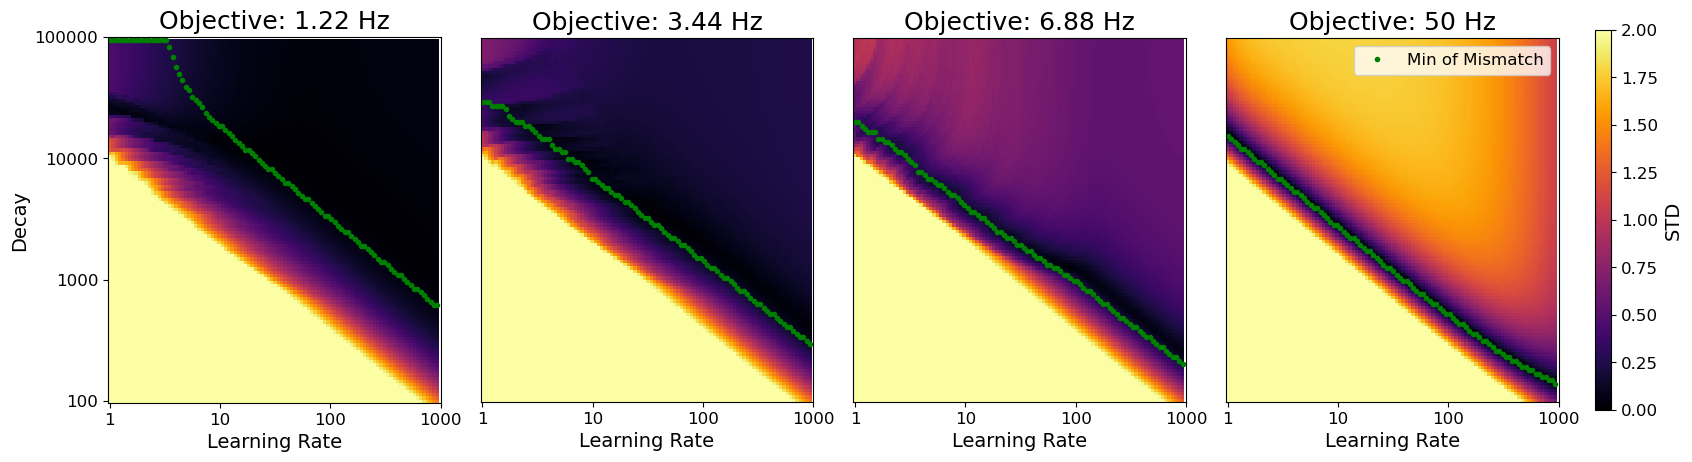

In [5]:

# Plotting STD
figname = 'FIG_2_B'
fig = plt.figure(figsize=(16, 10))
for o in range(nobjs):
    # STD over G
    ax = plt.subplot(1, nobjs, o + 1)
    plt.imshow(std_hom_fit[o], vmin=0, vmax=2, cmap='inferno', origin='lower', interpolation='none')
    plt.plot(range(0, nlr), min_mm_pos[o], 'g.', label='Min of Mismatch')
    
    plt.xticks(ticks=np.linspace(0, nlr, 4), labels=lr_labels, fontsize=TICKS)
    plt.xlabel('Learning Rate', fontsize=LABEL)
    plt.title('Objective: ' + str(obj_rates[o]) + ' Hz', fontsize=TITLE)
    
    if o == 0:
        plt.yticks(ticks=np.linspace(0, ndec, 4), labels=dec_labels, fontsize=TICKS)
        plt.ylabel('Decay', fontsize=LABEL)
    else:
        plt.yticks(ticks=[])
        
plt.legend(fontsize=LEGEND)
plt.tight_layout()

# Colorbar
cbar_ax2 = fig.add_axes([1, 0.31, 0.01, 0.38])
cbar2 = plt.colorbar(cax=cbar_ax2)
cbar2.set_label('STD', fontsize=COLORBAR)
cbar2.ax.tick_params(labelsize=TICKS)  # Adjust colorbar tick font size

plt.show()

# Save the figure
fig.savefig(figfold + figname + '.png', dpi=300)
fig.savefig(figfold + figname + '.pdf')


## FIC vs STR grid

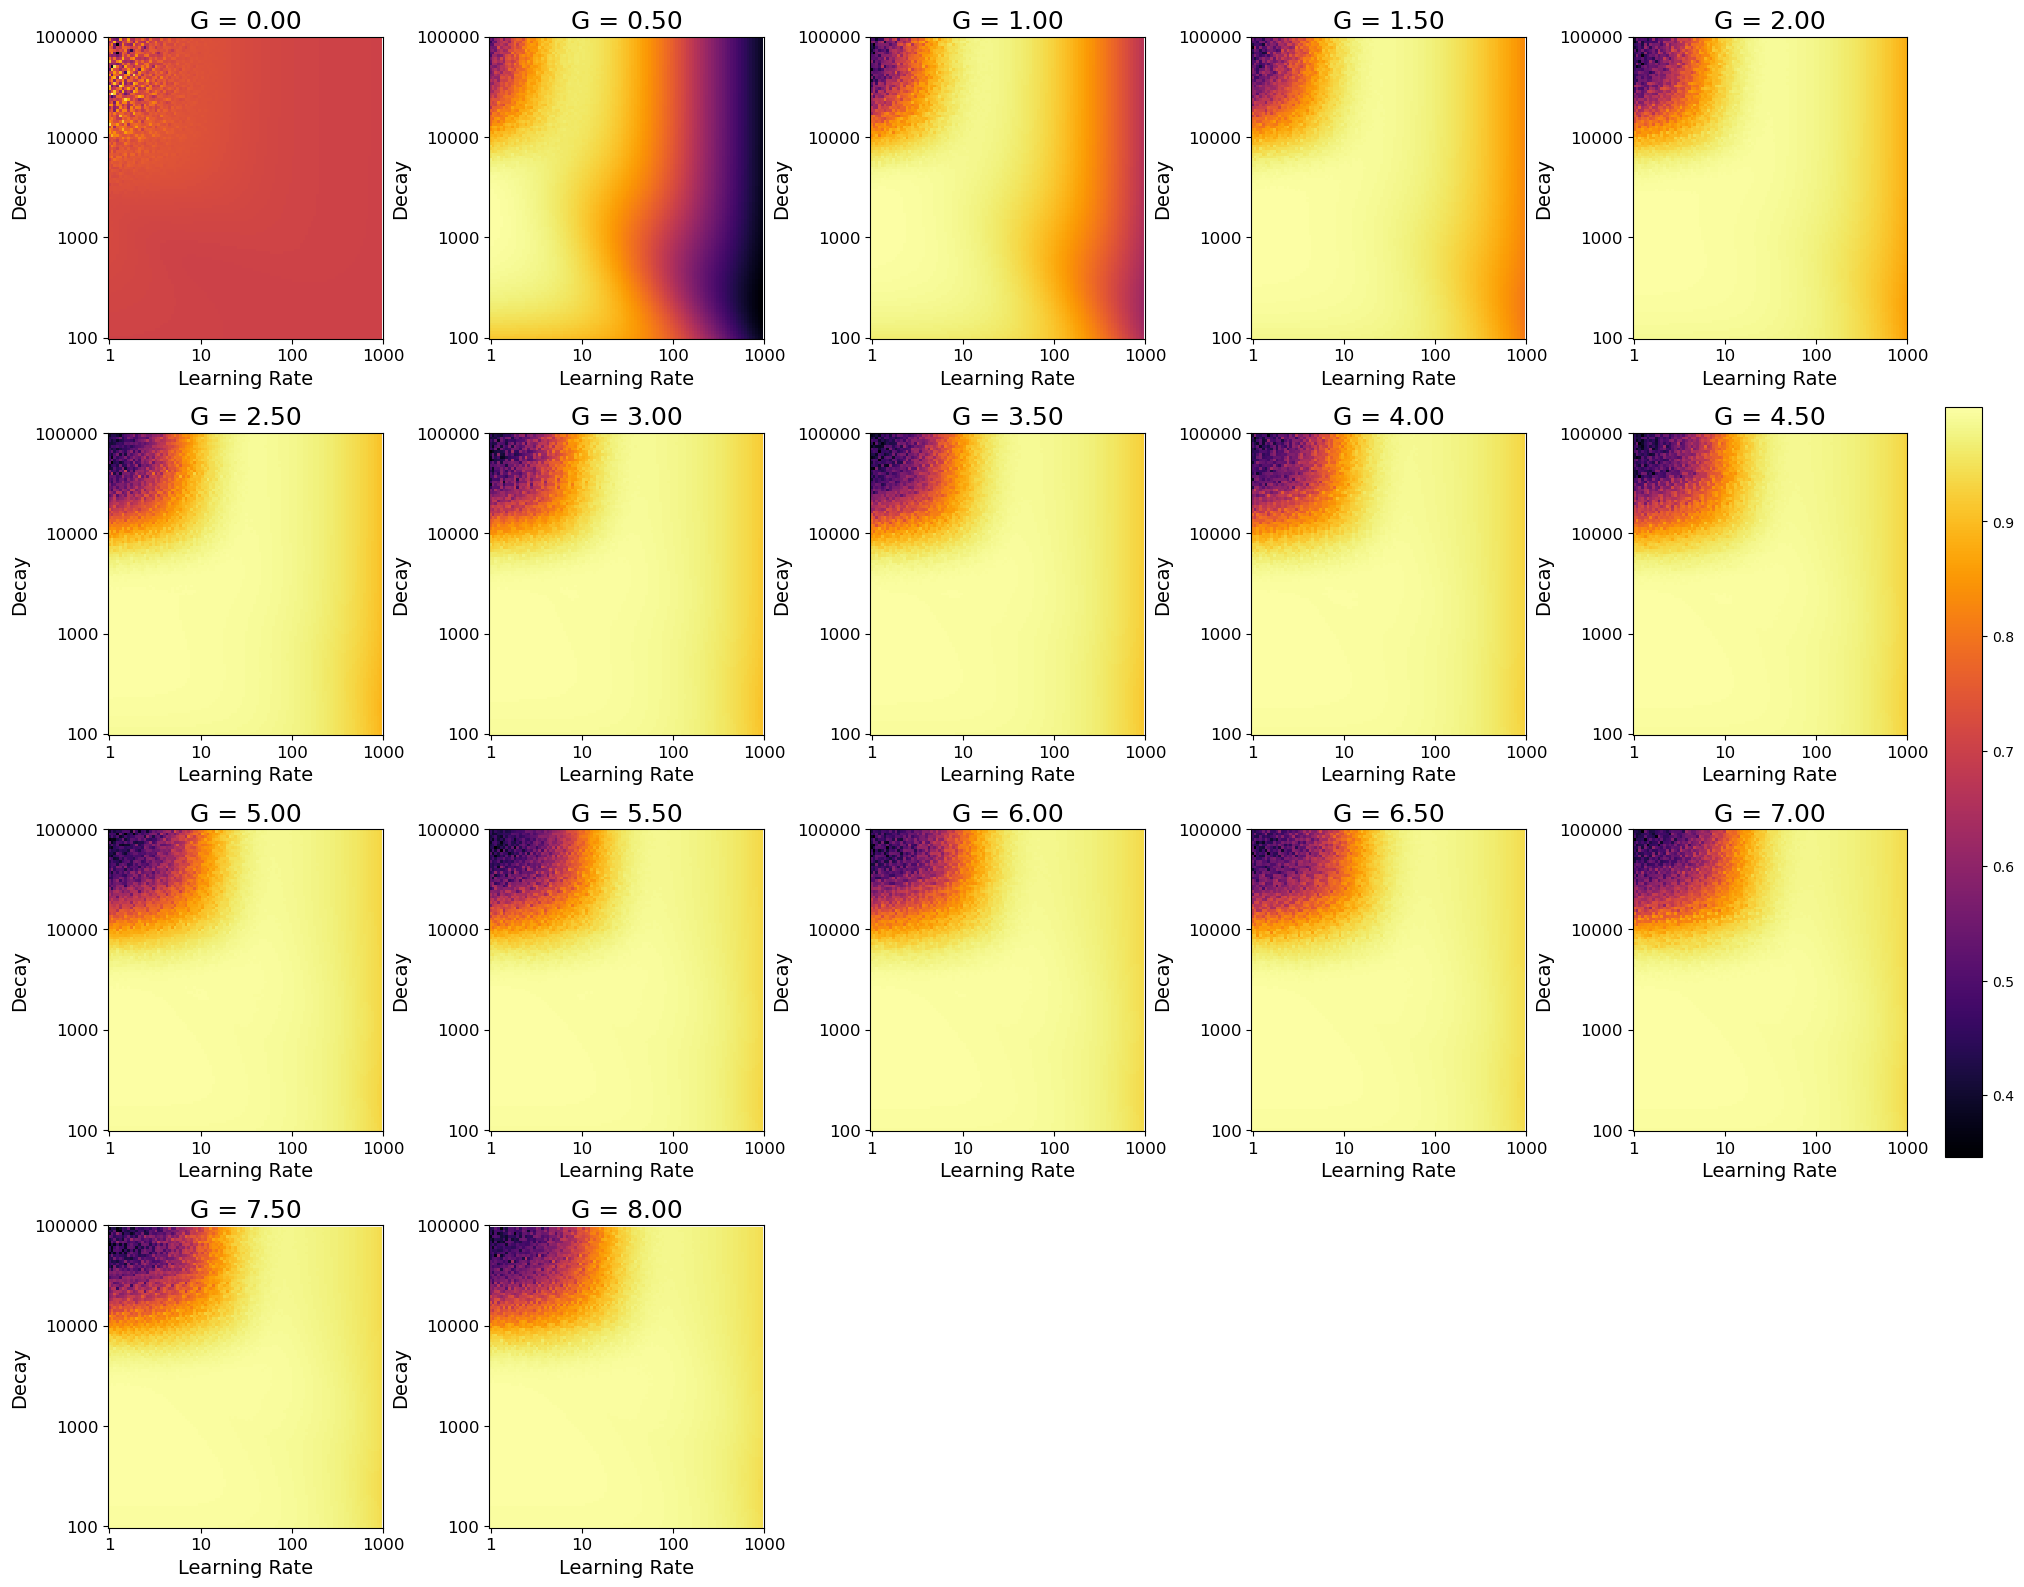

In [6]:
# Plot 17 subplots where you show a heatmap of the average accross the last dimension
figname = 'FIG_2_C'
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()
G_values = np.arange(0, 8.5, 0.5)
for i in range(17):
    ax = axes[i]
    heatmap_data = np.mean(fic_corr[:, :, :, i, :], axis=3)
    im = ax.imshow(heatmap_data, cmap='inferno', origin='lower', interpolation='none')
    ax.set_title(f'G = {G_values[i]:.2f}', fontsize=TITLE)
    ax.set_xticks(np.linspace(0, nlr, 4))
    ax.set_xticklabels(lr_labels, fontsize=TICKS)
    ax.set_xlabel('Learning Rate', fontsize=LABEL)
    ax.set_yticks(np.linspace(0, ndec, 4))
    ax.set_yticklabels(dec_labels, fontsize=TICKS)
    ax.set_ylabel('Decay', fontsize=LABEL)

# Hide any unused subplots
for j in range(17, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
plt.show()

# Save the figure
#fig.savefig(figfold + figname + '.png', dpi=300)
#fig.savefig(figfold + figname + '.pdf')

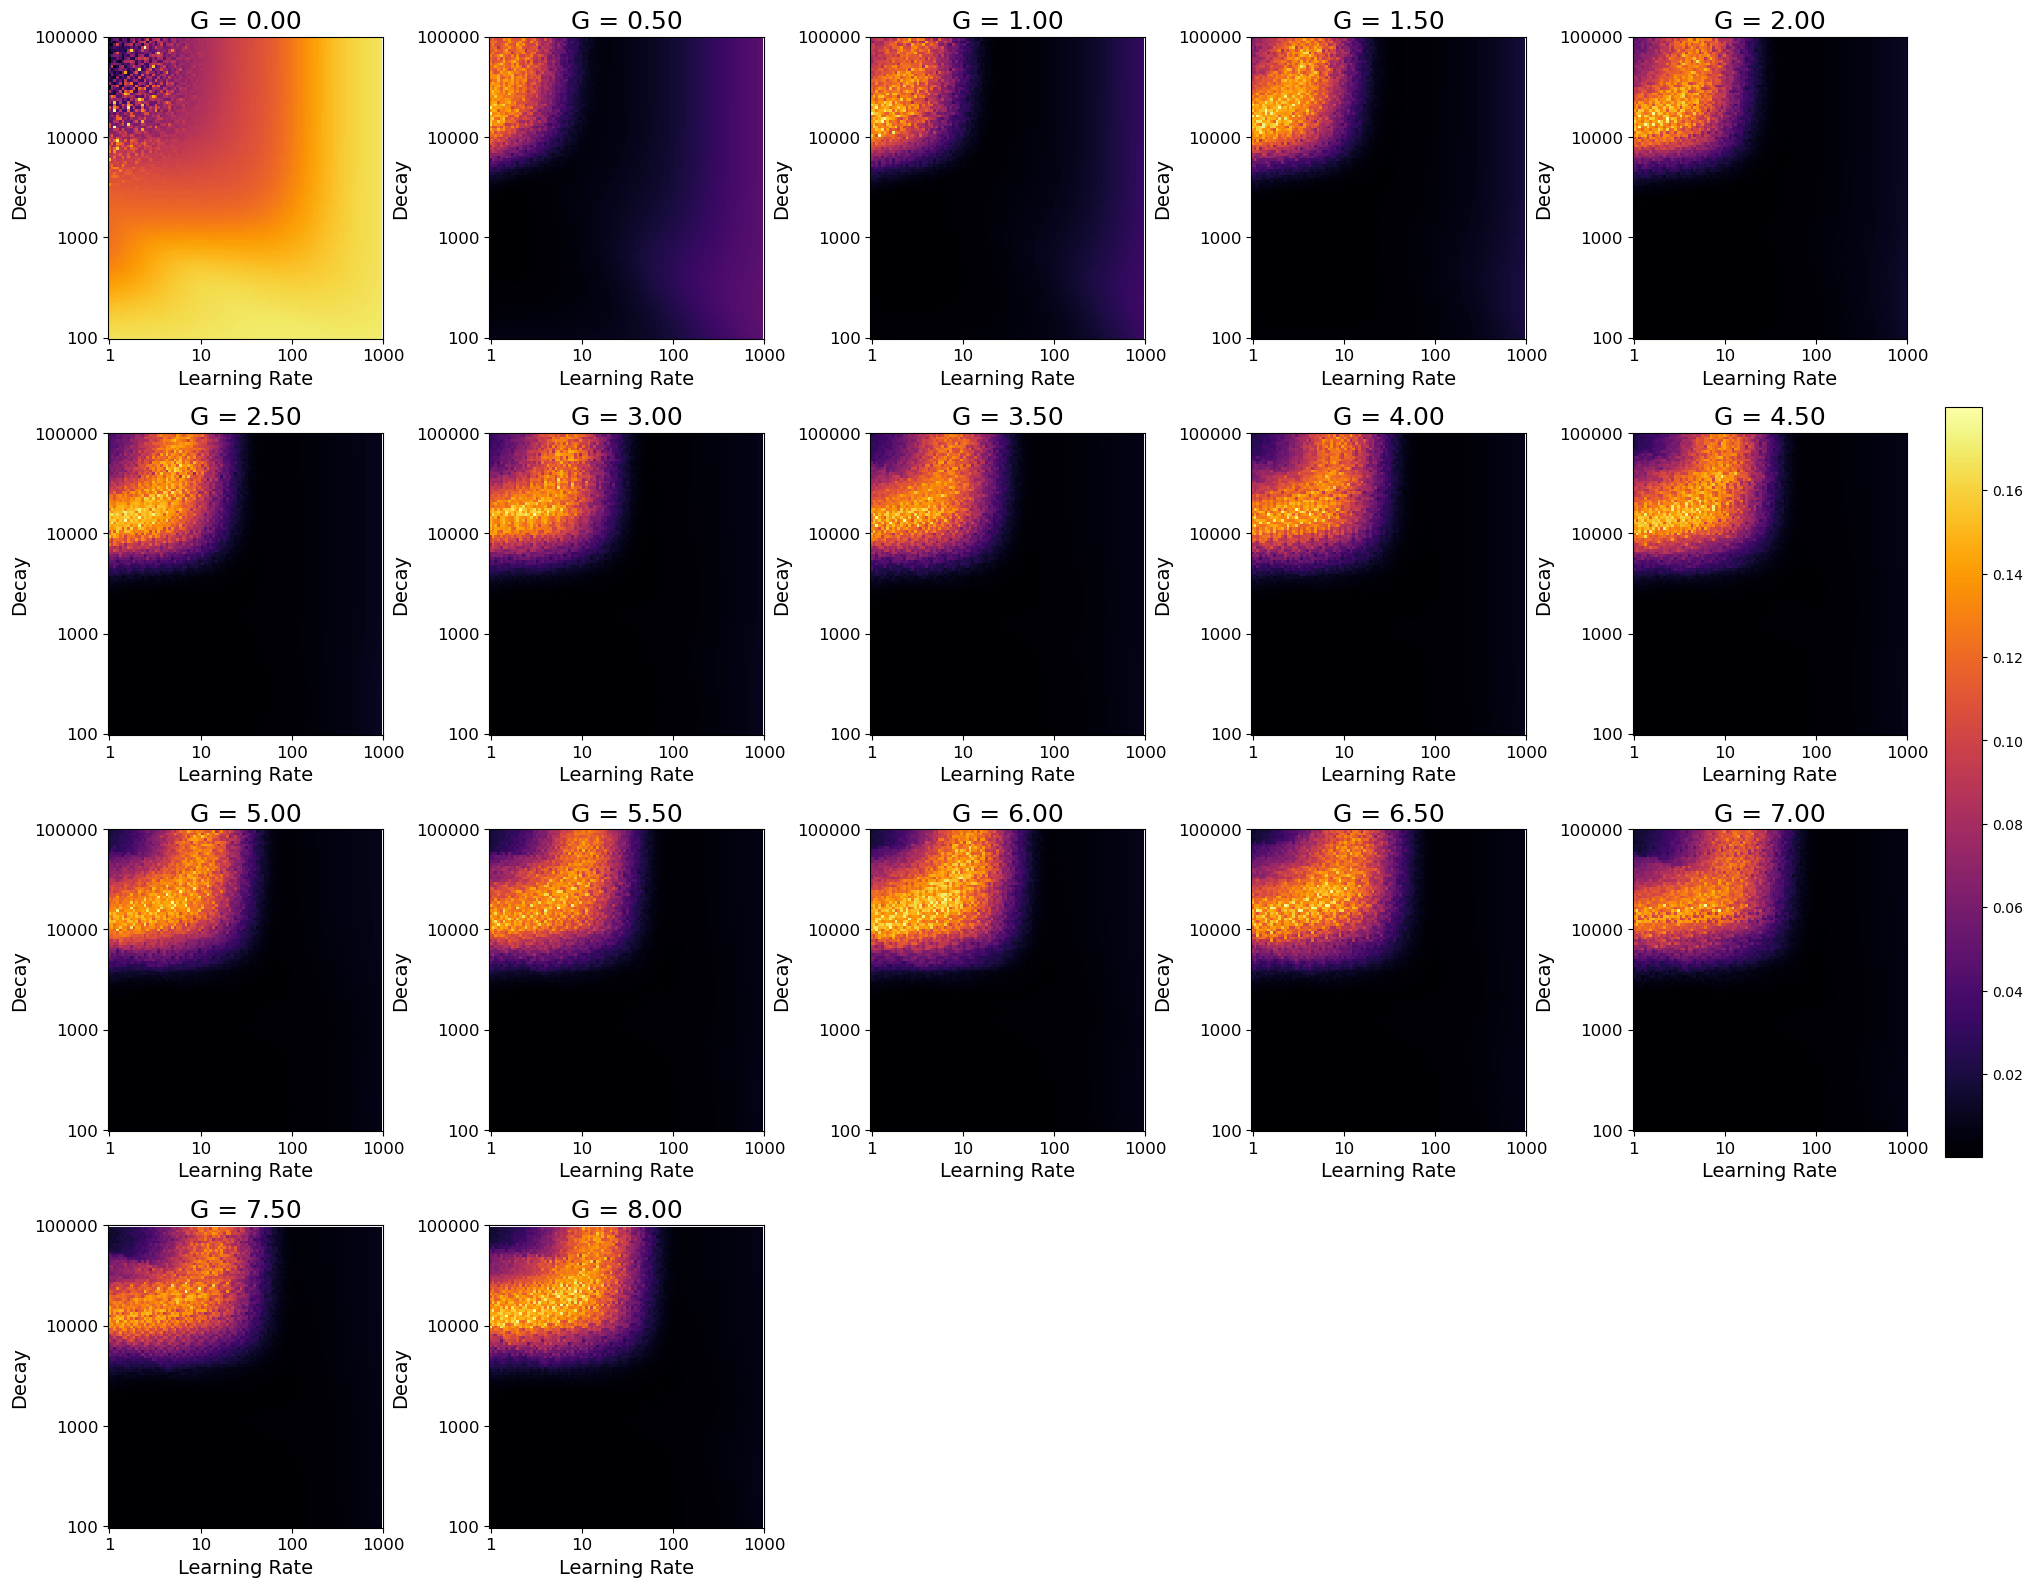

In [7]:
# Plot 17 subplots where you show a heatmap of the average accross the last dimension
figname = 'FIG_2_C'
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()
G_values = np.arange(0, 8.5, 0.5)
for i in range(17):
    ax = axes[i]
    #heatmap_data = np.mean(fic_corr[:, :, :, i, :], axis=3)
    # Create a heatmap with the index it takes to reach the maximum value
    heatmap_data = np.std(fic_corr[:, :, :, i, :], axis=3)
    im = ax.imshow(heatmap_data, cmap='inferno', origin='lower', interpolation='none')
    ax.set_title(f'G = {G_values[i]:.2f}', fontsize=TITLE)
    ax.set_xticks(np.linspace(0, nlr, 4))
    ax.set_xticklabels(lr_labels, fontsize=TICKS)
    ax.set_xlabel('Learning Rate', fontsize=LABEL)
    ax.set_yticks(np.linspace(0, ndec, 4))
    ax.set_yticklabels(dec_labels, fontsize=TICKS)
    ax.set_ylabel('Decay', fontsize=LABEL)

# Hide any unused subplots
for j in range(17, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
plt.show()

# Save the figure
#fig.savefig(figfold + figname + '.png', dpi=300)
#fig.savefig(figfold + figname + '.pdf')

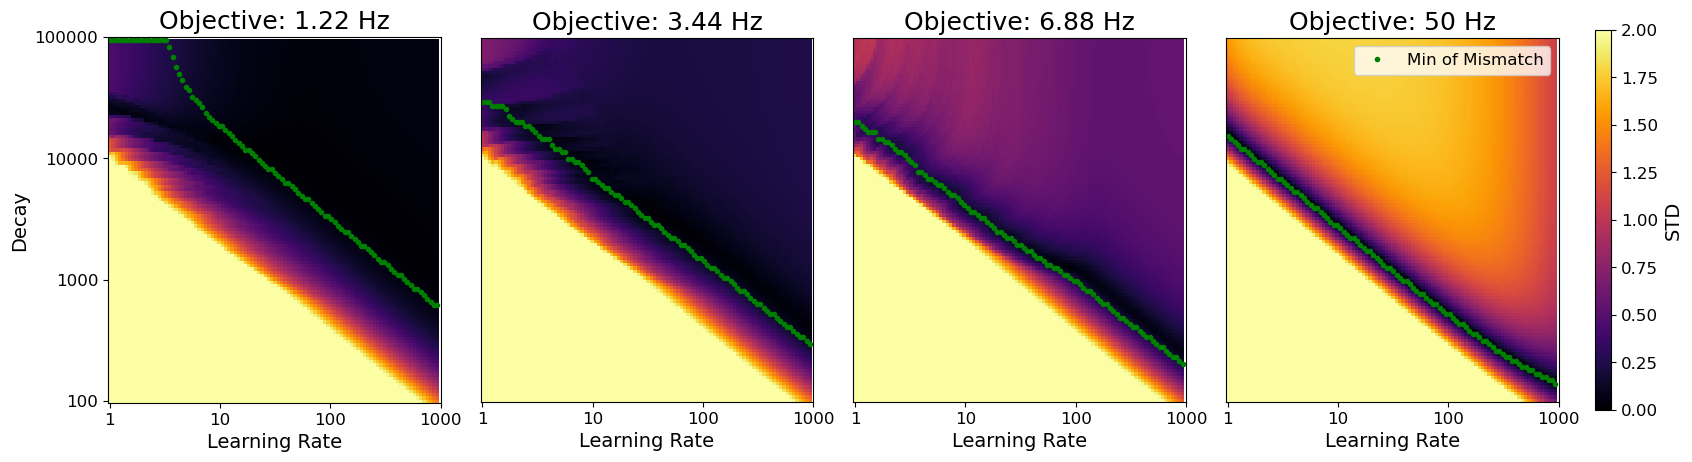

In [8]:

# Plotting STD
figname = 'FIG_2_C'
fig = plt.figure(figsize=(16, 10))
for o in range(nobjs):
    # STD over G
    ax = plt.subplot(1, nobjs, o + 1)
    plt.imshow(std_hom_fit[o], vmin=0, vmax=2, cmap='inferno', origin='lower', interpolation='none')
    plt.plot(range(0, nlr), min_mm_pos[o], 'g.', label='Min of Mismatch')
    
    plt.xticks(ticks=np.linspace(0, nlr, 4), labels=lr_labels, fontsize=TICKS)
    plt.xlabel('Learning Rate', fontsize=LABEL)
    plt.title('Objective: ' + str(obj_rates[o]) + ' Hz', fontsize=TITLE)
    
    if o == 0:
        plt.yticks(ticks=np.linspace(0, ndec, 4), labels=dec_labels, fontsize=TICKS)
        plt.ylabel('Decay', fontsize=LABEL)
    else:
        plt.yticks(ticks=[])
        
plt.legend(fontsize=LEGEND)
plt.tight_layout()

# Colorbar
cbar_ax2 = fig.add_axes([1, 0.31, 0.01, 0.38])
cbar2 = plt.colorbar(cax=cbar_ax2)
cbar2.set_label('STD', fontsize=COLORBAR)
cbar2.ax.tick_params(labelsize=TICKS)  # Adjust colorbar tick font size

plt.show()

# Save the figure
fig.savefig(figfold + figname + '.png', dpi=300)
fig.savefig(figfold + figname + '.pdf')


#### Comparison of static vs dynamic FIC



Acá falta agregar los paneles con correlación con la strength y la MSE.

También falta agregar en el primer panel el modelo estático que usar el promedio del FIC dinámico (mixed).


Hacer los gráficos usando el promedio de varias simulaciones para asegurarse que la inestabilidad del mixed es observada para diferentes codiciones iniciales.

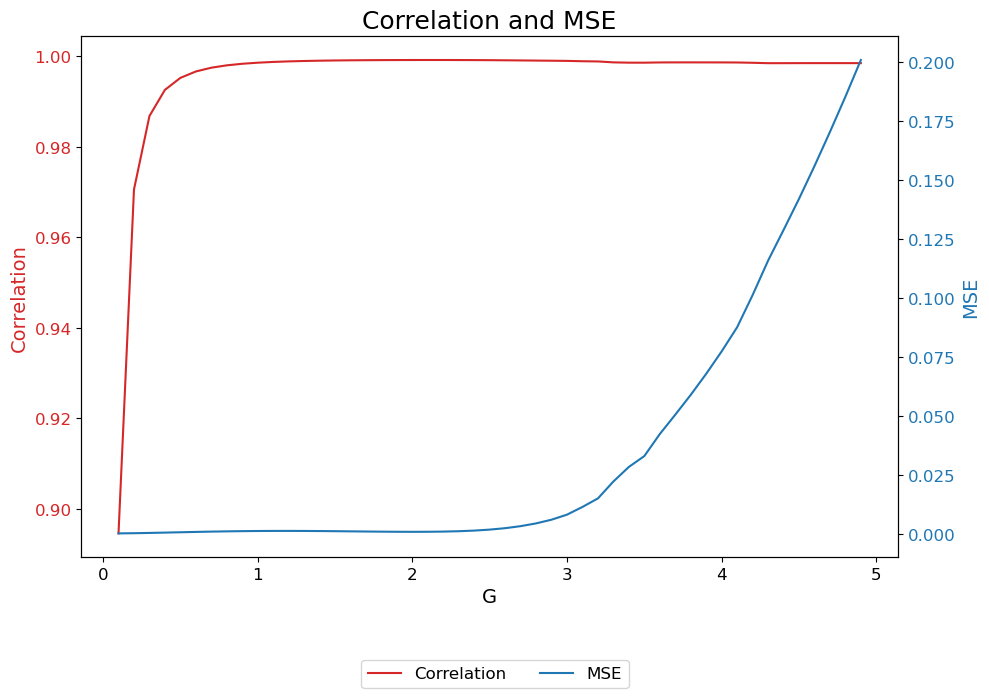

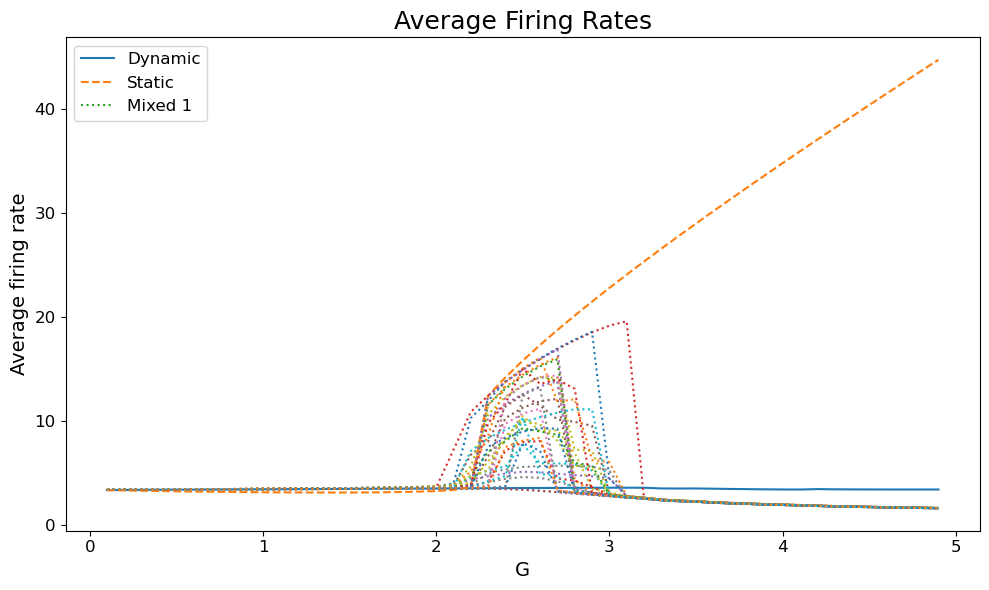

In [9]:
import numpy as np

# Define the data path
data_path = "/home/ivan.mindlin/Desktop/DatosParaRuben/ChequeoPreliminar"

# Load the results from the specified directory
mse_values = np.load(os.path.join(data_path, "mse_values.npy"))
corr_values = np.load(os.path.join(data_path, "corr_values.npy"))
avg_fr_dyn_values = np.load(os.path.join(data_path, "avg_fr_dyn_values.npy"))
avg_fr_stat_values = np.load(os.path.join(data_path, "avg_fr_stat_values.npy"))
avg_fr_mixed_values = np.load(os.path.join(data_path, "avg_fr_mixed_values.npy"))
stat_fic_values = np.load(os.path.join(data_path, "stat_fic_values.npy"))
dyn_fic_values = np.load(os.path.join(data_path, "dyn_fic_values.npy"))
G_values = np.load(os.path.join(data_path, "G_values.npy"))

# Panel 2_D: Shared y-axis plot for Correlation and MSE
fig, ax1 = plt.subplots(figsize=(10, 6))

# Correlation (Left y-axis)
color = 'tab:red'
ax1.set_xlabel('G', fontsize=LABEL)
ax1.set_ylabel('Correlation', color=color, fontsize=LABEL)
ax1.plot(G_values, corr_values, color=color, label='Correlation')
ax1.tick_params(axis='y', labelcolor=color, labelsize=TICKS)
ax1.tick_params(axis='x', labelsize=TICKS)

# MSE (Right y-axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('MSE', color=color, fontsize=LABEL)
ax2.plot(G_values, mse_values, color=color, label='MSE')
ax2.tick_params(axis='y', labelcolor=color, labelsize=TICKS)

# Add legends for clarity
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), fontsize=LEGEND, ncol=2)

fig.tight_layout()  # Adjust layout to avoid clipping
plt.title('Correlation and MSE', fontsize=TITLE)
plt.show()

# Panel 2_E: Average firing rates for dynamic, static, and mixed simulations
plt.figure(figsize=(10, 6))

plt.plot(G_values, np.mean(avg_fr_dyn_values, axis=1), label='Dynamic')
plt.plot(G_values, np.mean(avg_fr_stat_values, axis=1), '--', label='Static')

# Loop for mixed values
for i in range(avg_fr_mixed_values.shape[0]):
    mix_rep = np.mean(avg_fr_mixed_values[i, :, :], axis=1)
    plt.plot(G_values, mix_rep, ':', label=f'Mixed {i+1}' if i == 0 else "")

plt.xlabel('G', fontsize=LABEL)
plt.ylabel('Average firing rate', fontsize=LABEL)
plt.xticks(fontsize=TICKS)
plt.yticks(fontsize=TICKS)
plt.title('Average Firing Rates', fontsize=TITLE)
plt.legend(fontsize=LEGEND)
plt.tight_layout()

plt.show()


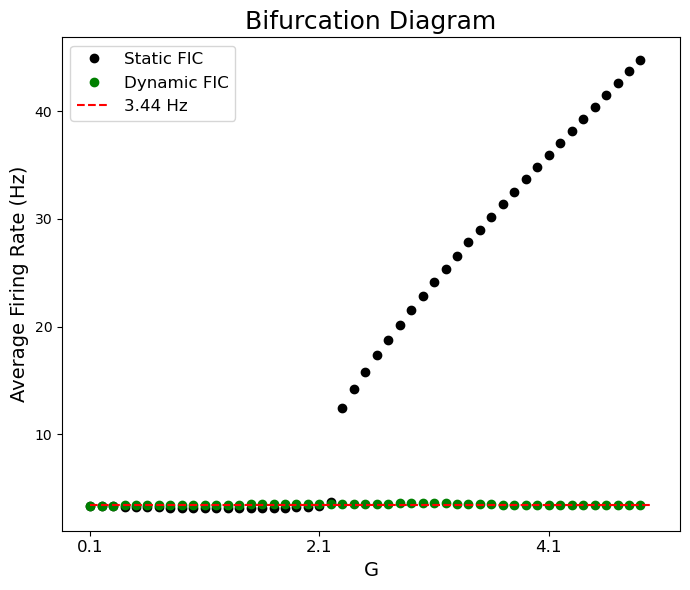

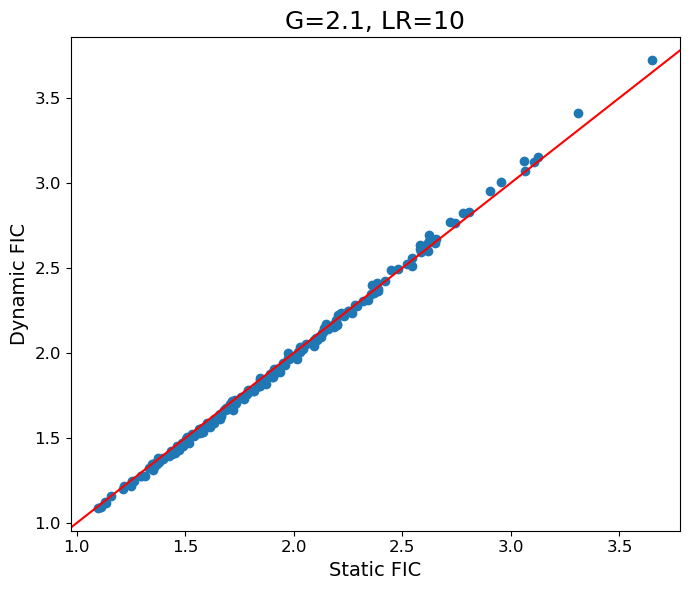

In [10]:
# Font sizes
TITLE = 18
LABEL = 14
TICKS = 12
LEGEND = 12

# Plotting FR vs G (Bifurcation diagram) - Separate into two independent figures
G_range = G_values
figname = 'FIG_2_F'

# First Figure: Bifurcation Diagram
fig1 = plt.figure(figsize=(7, 6))
plt.plot(np.mean(avg_fr_stat_values, axis=1), 'o', color='k', label='Static FIC', alpha=1)
plt.plot(np.mean(avg_fr_dyn_values, axis=1), 'o', color='g', label='Dynamic FIC', alpha=1)
plt.plot([0, len(G_range)], [3.44, 3.44], 'r--', label='3.44 Hz')

xtick_positions = range(0, len(G_range), 20)
plt.xticks(ticks=xtick_positions, labels=[f"{G_range[i]:.1f}" for i in xtick_positions], fontsize=TICKS)
plt.xlabel("G", fontsize=LABEL)
plt.ylabel("Average Firing Rate (Hz)", fontsize=LABEL)
plt.title("Bifurcation Diagram", fontsize=TITLE)
plt.legend(fontsize=LEGEND)
plt.tight_layout()
plt.show()

# Save First Figure
fig1.savefig(figfold + figname + '_bifurcation.svg', dpi=300)
fig1.savefig(figfold + figname + '_bifurcation.pdf', dpi=300)

# Second Figure: Static vs Dynamic FIC
fig2 = plt.figure(figsize=(7, 6))
plt.plot(stat_fic_values[20], dyn_fic_values[20], 'o')
plt.axline((1.5, 1.5), slope=1, color='red')
plt.xlabel('Static FIC', fontsize=LABEL)
plt.ylabel('Dynamic FIC', fontsize=LABEL)
plt.title('G=2.1, LR=10', fontsize=TITLE)
plt.xticks(fontsize=TICKS)
plt.yticks(fontsize=TICKS)
plt.tight_layout()
plt.show()

# Save Second Figure
fig2.savefig(figfold + figname + '_static_vs_dynamic.svg', dpi=300)
fig2.savefig(figfold + figname + '_static_vs_dynamic.pdf', dpi=300)


#### Neuromodulation with and without plasticity rule

In [11]:

# Neuromodulation
nm_mean_fr = [] # 0 is static, 1 dynamic
nm_std_fr = [] # 0 is static, 1 dynamic
nm_fc = [] # 0 is static, 1 dynamic
nm_fcd = [] # 0 is static, 1 dynamic
nm_mean_fr.append(np.load(datafolder+'neuromod/staticNMDA/mean_fr_grid.npy'))
nm_mean_fr.append(np.load(datafolder+'neuromod/dynamicNMDA/mean_fr_grid.npy'))
nm_std_fr.append(np.load(datafolder+'neuromod/staticNMDA/std_fr_grid.npy'))
nm_std_fr.append(np.load(datafolder+'neuromod/dynamicNMDA/std_fr_grid.npy'))

In [12]:
## Computing the correlation between receptor density and firing rates for each learning rate
LR_range = np.logspace(0,2.46,10)
#RECEPTORS = np.load("./data/Schaeffer200-Tian/D2_fallypride_hc49_jaworska_schaeffer200.npy")[:200]
RECEPTORS = np.load("./data/Schaeffer200-Tian/NMDA_ge179_hc29_galovic_schaeffer200.npy")[:200]
#RECEPTORS = np.load("./data/Schaeffer200-Tian/5HT2a_cimbi_hc29_beliveau_schaeffer200.npy")[:200]

RECEPTORS = RECEPTORS/max(RECEPTORS)-min(RECEPTORS)
RECEPTORS = RECEPTORS - max(RECEPTORS) + 1
receptors = np.reshape(RECEPTORS, (RECEPTORS.shape[0],1))
nlrs = 10
polyfit_out_static = [np.polyfit(np.squeeze(receptors), nm_mean_fr[0][x].T, 1, full=True) for x in range(nlrs)]
polyfit_out_dyn = [np.polyfit(np.squeeze(receptors), nm_mean_fr[1][x].T, 1, full=True) for x in range(nlrs)]
corr_out_static = [1-cdist(receptors.T, nm_mean_fr[0][x],metric='correlation') for x in range(nlrs)]
corr_out_dyn = [1-cdist(receptors.T, nm_mean_fr[1][x],metric='correlation') for x in range(nlrs)]

slope_rec_fr = [np.vstack([x[0][0],y[0][0]]) for x,y in zip(polyfit_out_static,polyfit_out_dyn)]
res_rec_fr = [np.vstack([x[0][1],y[0][1]]) for x,y in zip(polyfit_out_static,polyfit_out_dyn)]
corr_rec_fr = [np.vstack([x,y]) for x,y in zip(corr_out_static,corr_out_dyn)]


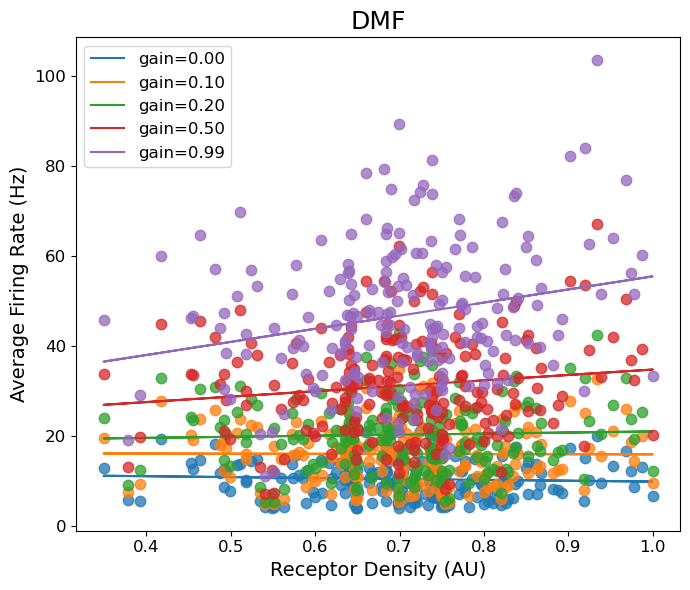

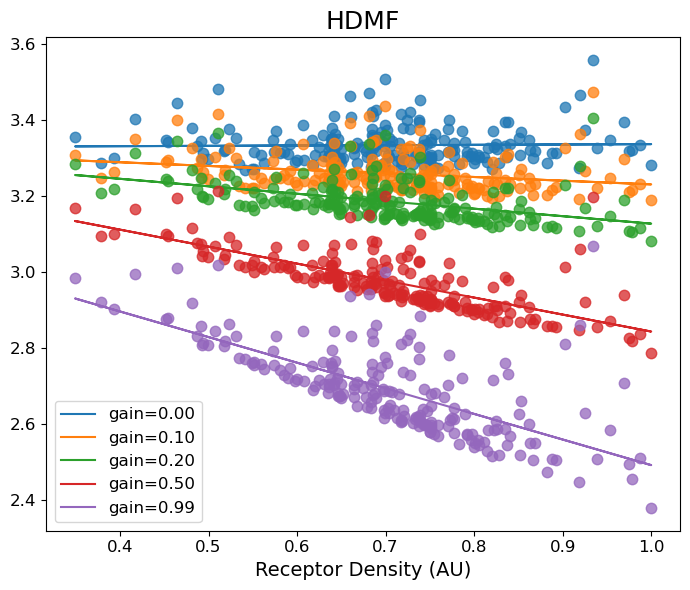

In [13]:

# Parameters
titles = ['DMF', 'HDMF']
lr_vals = np.logspace(0, 2.46, 10)
alpha_vals = [0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05]
receptors = RECEPTORS
gains2plot = [0, 10, 20, 50, 99]
nm_2_plot = [6, 8]
figname = 'fr_vs_neuromod_scatter'

# Figure 1: DMF
fig1 = plt.figure(figsize=(7, 6))
for g in gains2plot:
    # Scatter plot
    plot, = plt.plot(receptors, nm_mean_fr[0][nm_2_plot[0], g, :], '.', markersize=15, alpha=0.75)
    
    # Compute and plot the linear fit
    coeffs = np.polyfit(np.squeeze(receptors), nm_mean_fr[0][nm_2_plot[0], g, :], 1)
    linear_fit = np.poly1d(coeffs)
    plt.plot(receptors, linear_fit(receptors), '-', color=plot.get_color(), 
             label=f'gain={g/100:.2f}')

plt.xlabel('Receptor Density (AU)', fontsize=LABEL)
plt.ylabel('Average Firing Rate (Hz)', fontsize=LABEL)
plt.title(titles[0], fontsize=TITLE)
plt.xticks(fontsize=TICKS)
plt.yticks(fontsize=TICKS)
plt.legend(fontsize=LEGEND)
plt.tight_layout()
plt.show()

# Save FIG_3A
fig1.savefig(figfold + figname + '_DMF.svg', dpi=300)
fig1.savefig(figfold + figname + '_DMF.pdf', dpi=300)

# Figure 2: HDMF
fig2 = plt.figure(figsize=(7, 6))
for g in gains2plot:
    # Scatter plot
    plot, = plt.plot(receptors, nm_mean_fr[1][nm_2_plot[1], g, :], '.', markersize=15, alpha=0.75)
    
    # Compute and plot the linear fit
    coeffs = np.polyfit(np.squeeze(receptors), nm_mean_fr[1][nm_2_plot[1], g, :], 1)
    linear_fit = np.poly1d(coeffs)
    plt.plot(receptors, linear_fit(receptors), '-', color=plot.get_color(), 
             label=f'gain={g/100:.2f}')

plt.xlabel('Receptor Density (AU)', fontsize=LABEL)
plt.title(titles[1], fontsize=TITLE)
plt.xticks(fontsize=TICKS)
plt.yticks(fontsize=TICKS)
plt.legend(fontsize=LEGEND)
plt.tight_layout()
plt.show()

# Save FIG_3B
fig2.savefig(figfold + figname + '_HDMF.svg', dpi=300)
fig2.savefig(figfold + figname + '_HDMF.pdf', dpi=300)

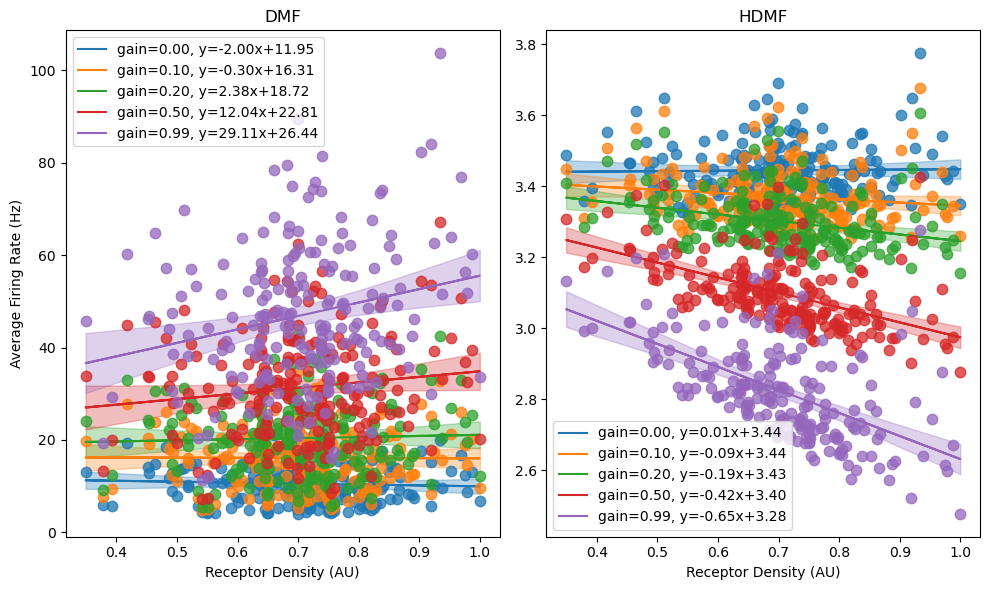

In [14]:
# FR modulation with the receptor density
import statsmodels.api as sm
titles= ['DMF','HDMF']
lr_vals = np.logspace(0,2.46,10)
alpha_vals = [0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95, 1.05]
#RECEPTORS = np.load("./data/Schaeffer200-Tian/D2_fallypride_hc49_jaworska_schaeffer200.npy")[:200]
RECEPTORS = np.load("./data/Schaeffer200-Tian/NMDA_ge179_hc29_galovic_schaeffer200.npy")[:200]
#RECEPTORS = np.load("./data/Schaeffer200-Tian/5HT2a_cimbi_hc29_beliveau_schaeffer200.npy")[:200]

RECEPTORS = RECEPTORS/max(RECEPTORS)-min(RECEPTORS)
RECEPTORS = RECEPTORS - max(RECEPTORS) + 1
receptors = np.reshape(RECEPTORS, (RECEPTORS.shape[0],1))
gains2plot = [0, 10, 20, 50, 99]

figname = 'fr_vs_neuromod_scatter'
fig = plt.figure(figsize=(10, 6))
nm_2_plot = [6,5]

for d in range(2):
    plt.subplot(1, 2, d + 1)
    for g in gains2plot:
        y_data = nm_mean_fr[d][nm_2_plot[d], g, :]
        plot, = plt.plot(receptors, y_data, '.', markersize=15, alpha=0.75)
        
        # Fit the linear regression model using statsmodels
        X = sm.add_constant(np.squeeze(receptors))  # Add an intercept to the model
        model = sm.OLS(y_data, X).fit()
        predictions = model.get_prediction(X)
        frame = predictions.summary_frame(alpha=0.05)
        
        # Plot the linear fit with the same color
        plt.plot(receptors, frame['mean'], '-', color=plot.get_color(),
                 label=f'gain={g/100:.2f}, y={model.params[1]:.2f}x+{model.params[0]:.2f}')
        
        # Plot the confidence interval
        sort_ids = np.argsort(np.squeeze(receptors))
        plt.fill_between(np.squeeze(receptors[sort_ids]).T, frame['mean_ci_lower'][sort_ids], 
                         frame['mean_ci_upper'][sort_ids], color=plot.get_color(), alpha=0.3)
        
        plt.xlabel('Receptor Density (AU)')
        plt.title(titles[d])
        if d == 0:
            plt.ylabel('Average Firing Rate (Hz)')
    plt.legend()

plt.tight_layout()
plt.show()


# fig.savefig(figfold+figname+'.png', dpi=300)
# fig.savefig(figfold+figname+'.pdf')

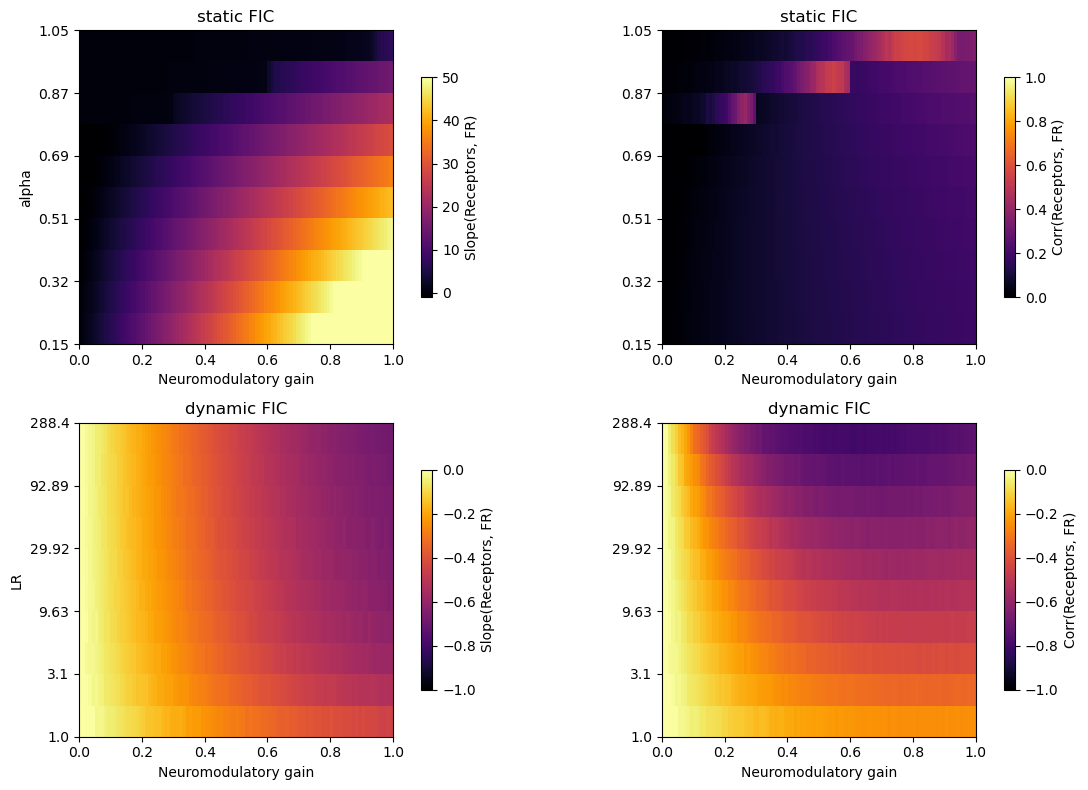

In [15]:
# LR vs Correlation
# LR_range = np.logspace(0,2.46,10)
# ,extent=(xmin,xmax,ymin,ymax))
titles = ['static FIC', 'dynamic FIC']
yticks = [np.floor(np.linspace(0.15, 1.05, 6)*100)/100, np.floor((np.logspace(0,2.46,6))*100)/100]
ylabel = ['alpha', 'LR']
slope_rec_fr_rs = np.dstack((slope_rec_fr))
res_rec_fr_rs = np.dstack((res_rec_fr))
corr_rec_fr_rs = np.dstack((corr_rec_fr))


s_vmin = [-1, -1]
s_vmax = [50, 0]
r_vmin = [0, 2.9]
r_vmax = [50, 3.3]
c_vmin = [0,-1]
c_vmax = [1,0]
figname = 'lr_vs_corr_fr_rec'
fig = plt.figure(figsize=(12, 8))
cont = 1

for p in range(2):
    # Slope
    plt.subplot(2,2,cont)
    plt.imshow(slope_rec_fr_rs[p,:,:].T,origin='lower', 
               vmin=s_vmin[p], vmax=s_vmax[p], cmap='inferno', interpolation='none', extent=(0,100,0,100))
    plt.title(titles[p])
    plt.colorbar(label='Slope(Receptors, FR)',shrink=0.7)    
    plt.yticks(ticks=np.linspace(0,100,6), labels=yticks[p])
    plt.ylabel(ylabel[p])
    plt.xticks(ticks=np.linspace(0,100,6), labels=np.linspace(0,100,6)/100)
    plt.xlabel('Neuromodulatory gain') 

    # Correlation
    plt.subplot(2,2,cont+1)
    plt.imshow(corr_rec_fr_rs[p,:,:].T,origin='lower', 
               vmin=c_vmin[p], vmax=c_vmax[p], cmap='inferno', interpolation='none', extent=(0,100,0,100))
    plt.title(titles[p])
    plt.colorbar(label='Corr(Receptors, FR)',shrink=0.7)    
    plt.yticks(ticks=np.linspace(0,100,6), labels=yticks[p])
    plt.xticks(ticks=np.linspace(0,100,6), labels=np.linspace(0,100,6)/100)
    plt.xlabel('Neuromodulatory gain') 
    # plt.ylabel(ylabel[p])

    cont=3
    


plt.tight_layout()
plt.show()

fig.savefig(figfold+figname+'.png', dpi=300)
fig.savefig(figfold+figname+'.pdf')

### II.- Fitting to fMRI

In [15]:
import fastdyn_fic_dmf as dmf

def compute_fcd(data, wsize, overlap, isubdiag, params):
    T, N = data.shape
    win_start = np.arange(0, T - params["wsize"] - 1, params["wsize"] - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + params["wsize"] + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0], isubdiag[1]]
    return fcd

C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2 * C / np.max(C)
params = dmf.default_params(C=C)
params['N'] = C.shape[0]
isubfcd = np.triu_indices(C.shape[1], 1)
burnout = 7
params["wsize"] = 30
overlap = 29
params['TR'] = 2
T = 250
params['dtt'] = 0.001  # Assuming 'dtt' is defined; adjust as needed
nb_steps = int(T * params['TR'] / params['dtt'])
win_start = np.arange(0, T - burnout - params["wsize"], params["wsize"] - overlap)
nwins = len(win_start)
nints = len(isubfcd[0])

emp_data = mat73.loadmat('data/BOLD_timeseries_Awake.mat')
emp_data = np.squeeze(np.array(emp_data['BOLD_timeseries_Awake']))[:,:200,:]
emp_data = emp_data[:,:,burnout:]


emp_fcds = []
for sub in range(emp_data.shape[0]):
    fcds = compute_fcd(emp_data[sub, :, :].T, params["wsize"], overlap, isubfcd, params)
    upp_tr_fcd = np.corrcoef(fcds.T)[np.triu_indices(nwins-1, 1)]
    emp_fcds.append(upp_tr_fcd)

emp_fc = np.mean(np.array([np.corrcoef(emp_data[sub, :, :]) for sub in range(emp_data.shape[0])]), axis=0)
emp_fcd = np.hstack((emp_fcds))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ks_2samp
col_pal = sns.color_palette()
# ------------------------------------------------------------------
# 1) LOAD THE DATA
# ------------------------------------------------------------------
datafolder = '/home/ivan.mindlin/Desktop/DatosParaRuben/'

fcs_grid = np.load(datafolder + 'FittedSimulations/fcs_grid.npy')

fcds_grid = np.load(datafolder + 'FittedSimulations/fcds_grid.npy')

sim_fcd_stat = list()
sim_fcd_dyn = list()
nreps = 100
sim_fcd_dim = 212
sim_fcd_triu_ids = np.triu_indices(sim_fcd_dim,k=1)
rep_ks = np.zeros((2,nreps))
rep_corr = np.zeros((2,nreps))
fc_triu_ids = np.triu_indices(200,k=1)
emp_triu = emp_fc[fc_triu_ids]
for r in range(nreps):
    
    # Static FCD
    aux = fcds_grid[0,r,:,:]
    sim_fcd_stat.append(aux[sim_fcd_triu_ids])
    rep_ks[0,r] = ks_2samp(aux[sim_fcd_triu_ids],emp_fcd)[0]
    # Static FC    
    sim_triu = fcs_grid[0,r,:,:]
    sim_triu = sim_triu[fc_triu_ids]
    aux = np.corrcoef(sim_triu,emp_triu)    
    rep_corr[0,r] = aux[0][1]
    # Dynamic FCD
    aux = fcds_grid[1,r,:,:]
    sim_fcd_dyn.append(aux[sim_fcd_triu_ids])
    rep_ks[1,r] = ks_2samp(aux[sim_fcd_triu_ids],emp_fcd)[0]
    # Dynamic FCD    
    sim_triu = fcs_grid[1,r,:,:]
    sim_triu = sim_triu[fc_triu_ids]
    aux = np.corrcoef(sim_triu,emp_triu)    
    rep_corr[1,r] = aux[0][1]


sim_fcd_stat = np.hstack((sim_fcd_stat))
sim_fcd_dyn = np.hstack((sim_fcd_dyn))

## Computing ks for each repetition

In [ ]:
# Plotting output of bayesian optimization
figname = 'bayesian_op_output'

fc_stat_alpha_space = np.squeeze(fc_fit[0]['alpha_space'])
fc_stat_g_space = np.squeeze(fc_fit[0]['G_space'])
fc_dyn_lr_space = np.squeeze(fc_fit[1]['lr_space'])
fc_dyn_g_space = np.squeeze(fc_fit[1]['G_space'])

fcd_stat_alpha_space = np.squeeze(fc_fit[0]['alpha_space'])
fcd_stat_g_space = np.squeeze(fc_fit[0]['G_space'])
fcd_dyn_lr_space = np.squeeze(fc_fit[1]['lr_space'])
fcd_dyn_g_space = np.squeeze(fc_fit[1]['G_space'])


fig = plt.figure(figsize=(12, 8))
# STATIC FC FIT
plt.subplot(2,2,1)
plt.imshow(fc_fit[0]['funcEvals_stat'].T, cmap='inferno', 
           extent=(fc_stat_g_space[0], fc_stat_g_space[-1], fc_stat_alpha_space[0], fc_stat_alpha_space[-1]), 
           origin='lower', interpolation='none', aspect='auto', vmin=0.75, vmax=1)
plt.colorbar(label='FC Fit (1 - correlation)')
plt.ylabel('alpha')
plt.xlabel('G')
plt.plot(fc_fit[0]['G_stat_fc'],fc_fit[0]['alpha_stat_fc'],'o',color='w', markerfacecolor='None')
# plt.plot(fc_fit[0]['alpha_stat_fc'],fc_fit[0]['G_stat_fc'],'o',color='w', markerfacecolor='None')
plt.title('Static: Fit to FC')

# DYNAMIC FC FIT
plt.subplot(2,2,2)
plt.imshow(fc_fit[1]['funcEvals'].T, cmap='inferno', 
           extent=(fc_dyn_g_space[0], fc_dyn_g_space[-1], fc_dyn_lr_space[0], fc_dyn_lr_space[-1]), 
           origin='lower', interpolation='none', aspect='auto', vmin=0.75, vmax=1)
plt.colorbar(label='FC Fit (1 - correlation)')
plt.ylabel('Learning Rate')
plt.xlabel('G')
plt.plot(fc_fit[1]['G_dyn_fc'],fc_fit[1]['lr_dyn_fc'],'o',color='w', markerfacecolor='None')
plt.title('Dynamic: Fit to FC')

# STATIC FCD FIT
plt.subplot(2,2,3)
plt.imshow(fcd_fit[0]['funcEvals_stat'].T, cmap='inferno', 
           extent=(fcd_stat_g_space[0], fcd_stat_g_space[-1], fcd_stat_alpha_space[0], fcd_stat_alpha_space[-1]), 
           origin='lower', interpolation='none', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='KS distance')
plt.ylabel('alpha')
plt.xlabel('G')
plt.plot(fcd_fit[0]['G_stat_fcd'],fcd_fit[0]['alpha_stat_fcd'],'o',color='w', markerfacecolor='None')
plt.title('Static: Fit to FCD')

# DYNAMIC FCD FIT
plt.subplot(2,2,4)
plt.imshow(fcd_fit[1]['funcEvals'].T, cmap='inferno', 
           extent=(fcd_dyn_g_space[0], fcd_dyn_g_space[-1], fcd_dyn_lr_space[0], fcd_dyn_lr_space[-1]), 
           origin='lower', interpolation='none', aspect='auto', vmin=0, vmax=1 )
plt.colorbar(label='KS distance')
plt.ylabel('Learning Rate')
plt.xlabel('G')
plt.plot(fcd_fit[1]['G_dyn_fcd'],fcd_fit[1]['lr_dyn_fcd'],'o',color='w', markerfacecolor='None')
plt.title('Dynamic: Fit to FCD')



plt.tight_layout()
plt.show()

# fig.savefig(figfold+figname+'.png', dpi=300)
# fig.savefig(figfold+figname+'.pdf')



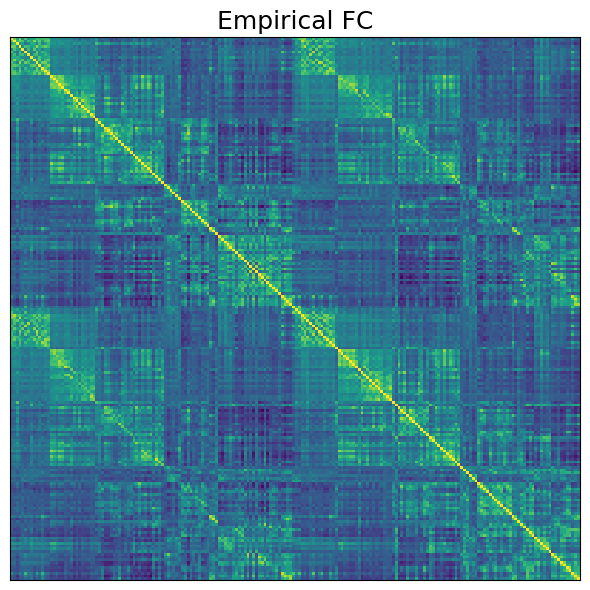

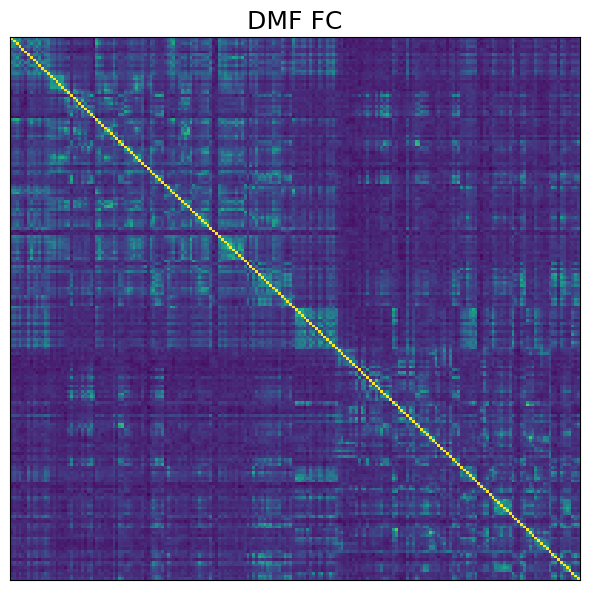

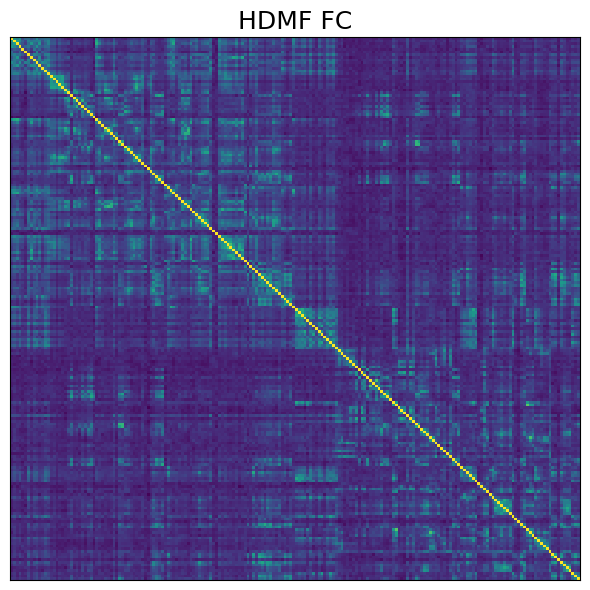

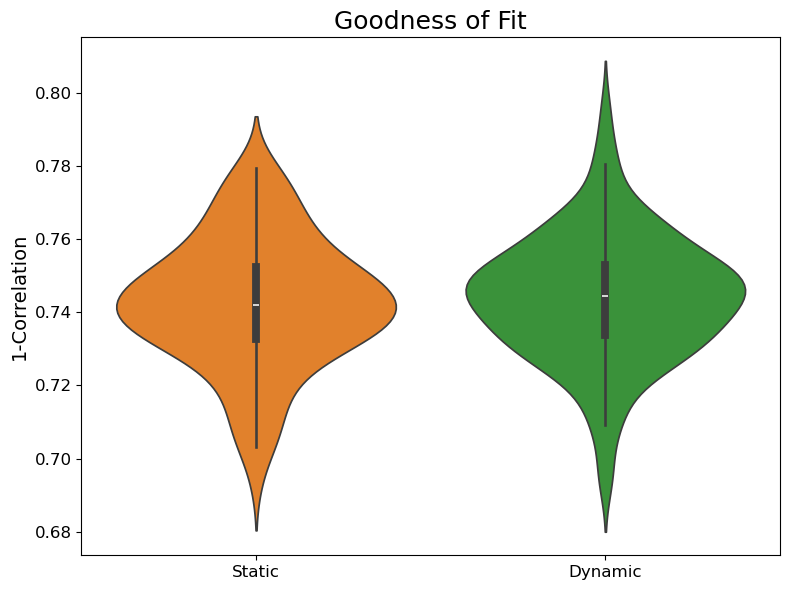

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Font sizes
TITLE = 18
LABEL = 14
TICKS = 12

# Parameters
figname_base = 'FIG_3_'
col_pal = sns.color_palette()

# Plot A: Empirical FC
fig_a = plt.figure(figsize=(6, 6))
plt.imshow(emp_fc, interpolation='none', aspect='auto')
plt.title('Empirical FC', fontsize=TITLE)
plt.xticks([])  # Remove x-tick labels
plt.yticks([])  # Remove y-tick labels
plt.tight_layout()
fig_a.savefig(figfold + figname_base + 'A.png', dpi=300)
fig_a.savefig(figfold + figname_base + 'A.svg', dpi=300)
plt.show()

# Plot B: DMF FC

fig_b = plt.figure(figsize=(6, 6))
ave_static_fc = np.mean(fcs_grid[0,:16,:,:],axis=0)
plt.imshow(ave_static_fc, interpolation='none', aspect='auto')
plt.title('DMF FC', fontsize=TITLE)
plt.xticks([])  # Remove x-tick labels
plt.yticks([])  # Remove y-tick labels
plt.tight_layout()
fig_b.savefig(figfold + figname_base + 'B.png', dpi=300)
fig_b.savefig(figfold + figname_base + 'B.svg', dpi=300)
plt.show()

# Plot C: HDMF FC
fig_c = plt.figure(figsize=(6, 6))
ave_dynamic_fc = np.mean(fcs_grid[0,:16,:,:],axis=0)
plt.imshow(ave_dynamic_fc, interpolation='none', aspect='auto')
plt.title('HDMF FC', fontsize=TITLE)
plt.xticks([])  # Remove x-tick labels
plt.yticks([])  # Remove y-tick labels
plt.tight_layout()
fig_c.savefig(figfold + figname_base + 'C.png', dpi=300)
fig_c.savefig(figfold + figname_base + 'C.svg', dpi=300)
plt.show()

# Plot D: Violin Plot for Goodness of Fit
fig_d = plt.figure(figsize=(8, 6))
sns.violinplot(data=1 - rep_corr.T, palette=col_pal[1:3])
plt.xticks(ticks=[0, 1], labels=['Static', 'Dynamic'], fontsize=TICKS)
plt.yticks(fontsize=TICKS)
plt.ylabel('1-Correlation', fontsize=LABEL)
plt.title('Goodness of Fit', fontsize=TITLE)
plt.tight_layout()
fig_d.savefig(figfold + figname_base + 'D.png', dpi=300)
fig_d.savefig(figfold + figname_base + 'D.svg', dpi=300)
plt.show()


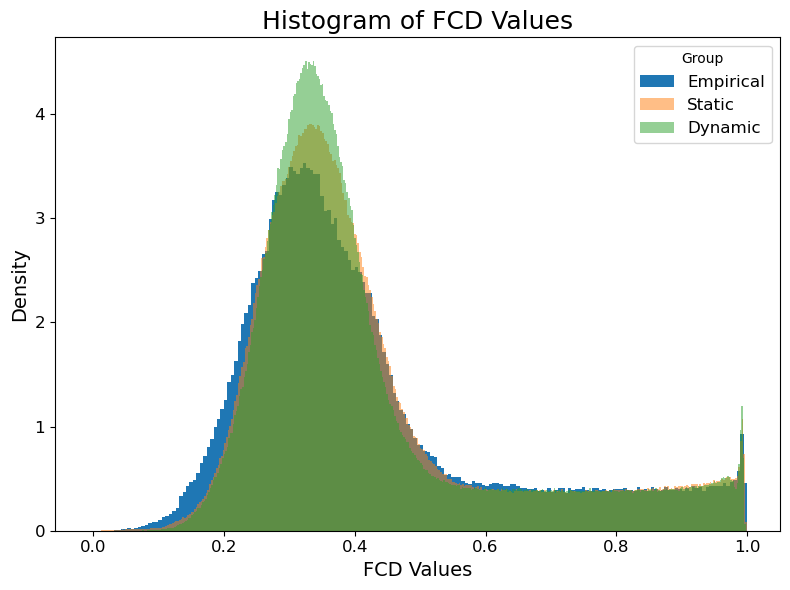

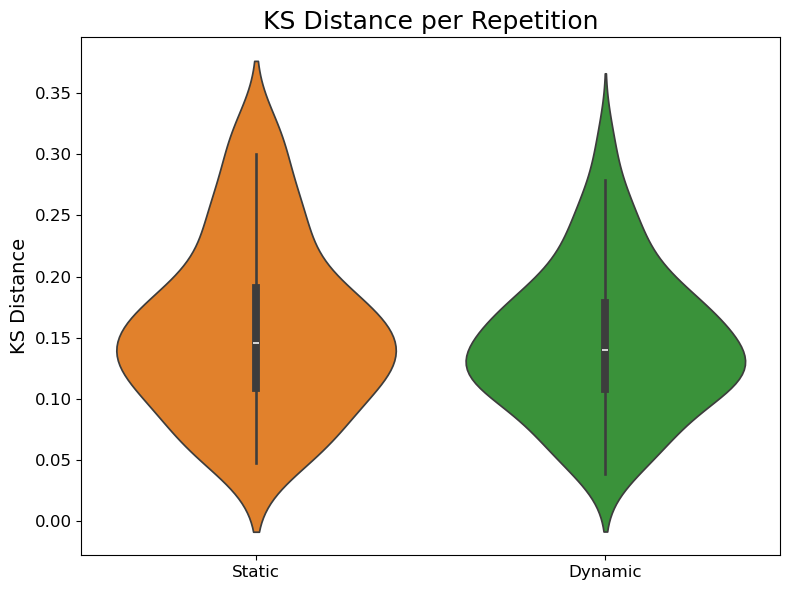

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Font sizes
TITLE = 18
LABEL = 14
TICKS = 12
LEGEND = 12

# Parameters
figname_base = 'FIG_3_'
col_pal = sns.color_palette()

# Plot A: Histogram of FCD Values
fig_a = plt.figure(figsize=(8, 6))
sns.histplot(emp_fcd, stat='density', legend=False, linewidth=0, label='Empirical', alpha=1, color=col_pal[0])
sns.histplot(sim_fcd_stat, stat='density', legend=False, linewidth=0, label='Static', alpha=0.5, color=col_pal[1])
sns.histplot(sim_fcd_dyn, stat='density', legend=False, linewidth=0, label='Dynamic', alpha=0.5, color=col_pal[2])
plt.xlabel('FCD Values', fontsize=LABEL)
plt.ylabel('Density', fontsize=LABEL)
plt.title('Histogram of FCD Values', fontsize=TITLE)
plt.xticks(fontsize=TICKS)
plt.yticks(fontsize=TICKS)
plt.legend(fontsize=LEGEND, title='Group')
plt.tight_layout()
fig_a.savefig(figfold + figname_base + 'E.png', dpi=300)
fig_a.savefig(figfold + figname_base + 'E.svg', dpi=300)
plt.show()

# Plot B: Violin Plot of KS Distance
fig_b = plt.figure(figsize=(8, 6))
sns.violinplot(data=rep_ks.T, palette=col_pal[1:3])
plt.xticks(ticks=[0, 1], labels=['Static', 'Dynamic'], fontsize=TICKS)
plt.ylabel('KS Distance', fontsize=LABEL)
plt.title('KS Distance per Repetition', fontsize=TITLE)
plt.yticks(fontsize=TICKS)
plt.tight_layout()
fig_b.savefig(figfold + figname_base + 'F.png', dpi=300)
fig_b.savefig(figfold + figname_base + 'F.svg', dpi=300)
plt.show()


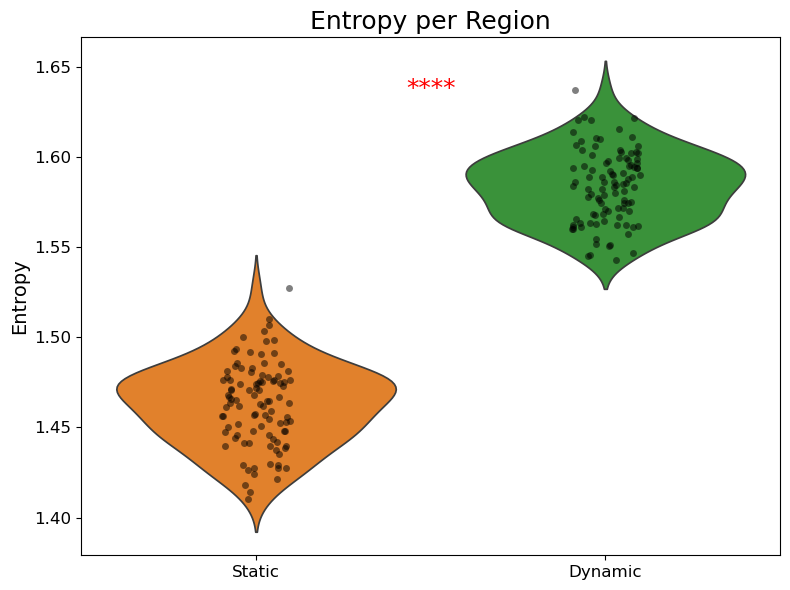

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp

# Font sizes
TITLE = 18
LABEL = 14
TICKS = 12

# Parameters
figname = 'FIG_3_'
col_pal = sns.color_palette()

# Load data
entropies_stat = np.load(datafolder + 'FittedSimulations/stat_entropy.npy')
entropies_dyn = np.load(datafolder + 'FittedSimulations/dyn_entropy.npy')

# Compute averaged entropies
averaged_entropies_stat = np.mean(entropies_stat, axis=1)
averaged_entropies_dyn = np.mean(entropies_dyn, axis=1)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Stripplot
sns.stripplot(data=[averaged_entropies_stat, averaged_entropies_dyn], jitter=True, color='black', alpha=0.5, ax=ax)

# Violinplot
sns.violinplot(data=[averaged_entropies_stat, averaged_entropies_dyn], inner=None, palette=col_pal[1:3], ax=ax)

# Title and labels
ax.set_title('Entropy per Region', fontsize=TITLE)
ax.set_ylabel('Entropy', fontsize=LABEL)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Static', 'Dynamic'], fontsize=TICKS)
ax.tick_params(axis='y', labelsize=TICKS)

# Perform paired test (Kolmogorov-Smirnov test) and annotate
_, p = ks_2samp(averaged_entropies_stat, averaged_entropies_dyn)
if p < 0.05:
    ax.text(0.5, 0.9, '****', ha='center', va='center', transform=ax.transAxes, fontsize=TITLE, color='red')

# Layout and save
plt.tight_layout()
fig.savefig(figfold + figname + 'G.png', dpi=300)
fig.savefig(figfold + figname + 'G.svg', dpi=300)
plt.show()


In [64]:
# Statistcal tests between distributions
from scipy.stats import wilcoxon
ks, p_fcd = ks_2samp(rep_ks[0,:],rep_ks[1,:])
ks_corr, p_fc = ks_2samp(rep_corr[0,:],rep_corr[1,:])

_, w_p_fcd= wilcoxon(rep_ks[0,:],rep_ks[1,:])
_, w_p_fc= wilcoxon(rep_corr[0,:],rep_corr[1,:])
[p_fcd, p_fc, w_p_fcd,w_p_fc]

[0.009878183186176536,
 0.0061340334218580265,
 0.0005853250706648852,
 3.3463326057616274e-10]

### III.- A potential mechanism for whole-brain slow-waves

In [31]:
peak_val_ac_grid = np.load(datafolder+'slow_waves/peak_autocorrelation_grid.npy')
peak_time_ac_grid = np.load(datafolder+'slow_waves/peak_time_grid.npy')
corr_to_sc_grid = np.load(datafolder+'slow_waves/corr_to_sc_grid.npy')
rates_grid = np.load(datafolder+'slow_waves/rates_grid.npy')
homeo_fit_grid = np.load(datafolder+'slow_waves/homeostatic_fittness_grid.npy')

In [32]:
peak_val_ac_grid.shape

(8, 60, 100)

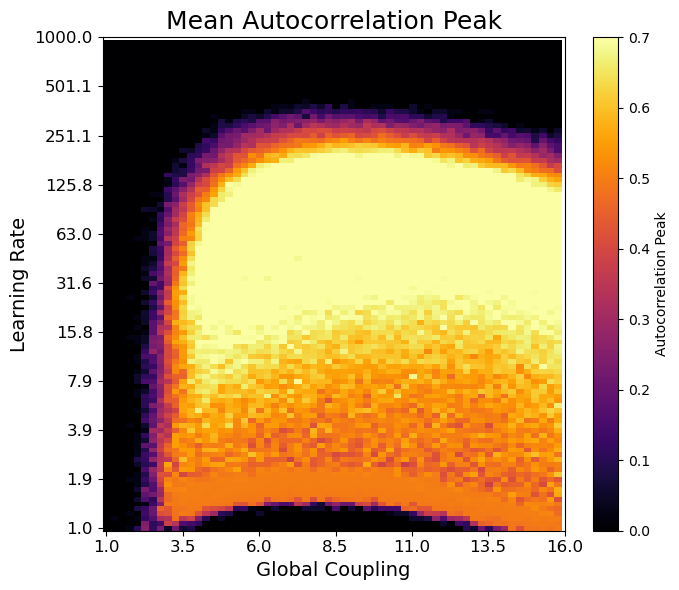

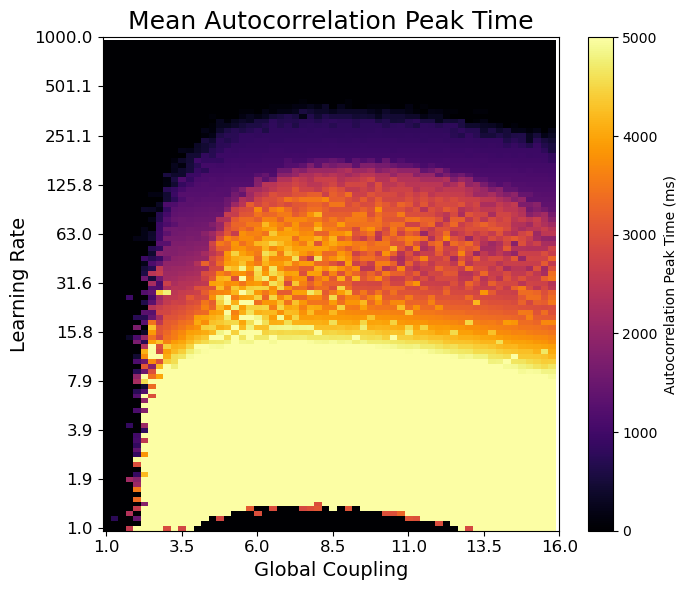

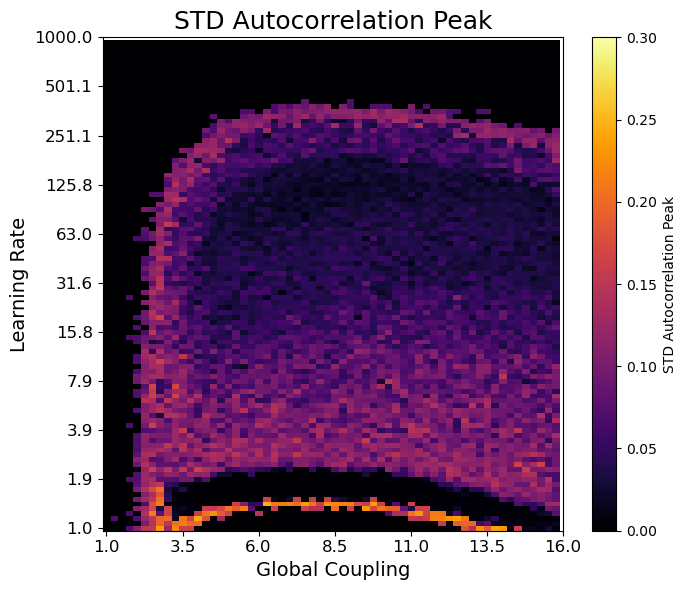

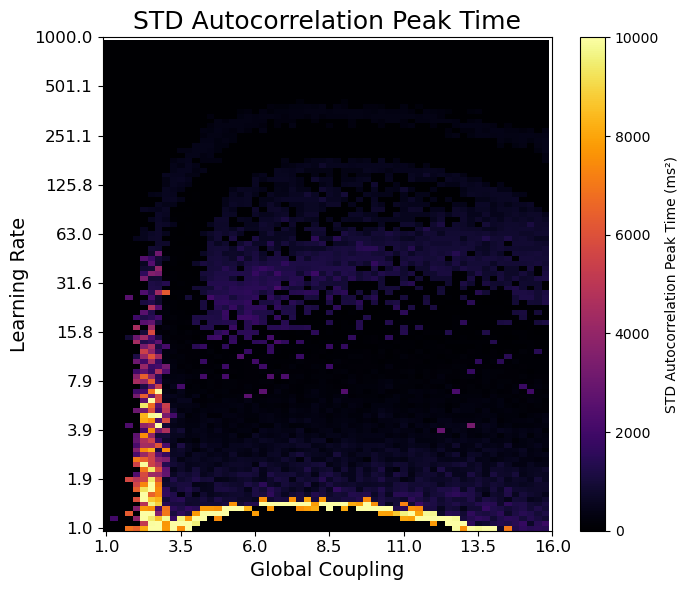

In [36]:

# Parameters
figname = 'slow_waves_ACF_peak_and_time'
G_max = 16
G_step = 0.25
G_range = np.arange(1, G_max, G_step)
LR_range = np.logspace(0, 3, 100)
ngs = len(G_range)
nlrs = len(LR_range)

# Define common y and x ticks
yticks = np.arange(0, nlrs + 1, 10)
ytick_labels = np.floor(10 * np.logspace(0, 3, 11)) / 10
xticks = np.arange(0, ngs + 1, 10)
xtick_labels = np.linspace(1, G_max, 7)

# FIG_5A: Mean Autocorrelation Peak
fig1 = plt.figure(figsize=(7, 6))
plt.imshow(np.mean(peak_val_ac_grid, axis=0).T, vmin=0, vmax=0.7, cmap='inferno',
           interpolation='none', origin='lower', aspect='auto')
plt.yticks(ticks=yticks, labels=ytick_labels, fontsize=TICKS)
plt.xticks(ticks=xticks, labels=xtick_labels, fontsize=TICKS)
plt.ylabel('Learning Rate', fontsize=LABEL)
plt.xlabel('Global Coupling', fontsize=LABEL)
plt.colorbar(label='Autocorrelation Peak')
plt.title('Mean Autocorrelation Peak', fontsize=TITLE)
plt.tight_layout()
plt.show()
fig1.savefig(figfold + figname + '_FIG_5A.svg', dpi=300)
fig1.savefig(figfold + figname + '_FIG_5A.pdf', dpi=300)

# FIG_5B: Mean Autocorrelation Peak Time
fig2 = plt.figure(figsize=(7, 6))
plt.imshow(np.mean(peak_time_ac_grid, axis=0).T, vmin=0, vmax=5000, cmap='inferno',
           interpolation='none', origin='lower', aspect='auto')
plt.yticks(ticks=yticks, labels=ytick_labels, fontsize=TICKS)
plt.xticks(ticks=xticks, labels=xtick_labels, fontsize=TICKS)
plt.ylabel('Learning Rate', fontsize=LABEL)
plt.xlabel('Global Coupling', fontsize=LABEL)
plt.colorbar(label='Autocorrelation Peak Time (ms)')
plt.title('Mean Autocorrelation Peak Time', fontsize=TITLE)
plt.tight_layout()
plt.show()
fig2.savefig(figfold + figname + '_FIG_5B.svg', dpi=300)
fig2.savefig(figfold + figname + '_FIG_5B.pdf', dpi=300)

# FIG_5C: STD of Autocorrelation Peak
fig3 = plt.figure(figsize=(7, 6))
plt.imshow(np.std(peak_val_ac_grid, axis=0).T, vmin=0, vmax=0.3, cmap='inferno',
           interpolation='none', origin='lower', aspect='auto')
plt.yticks(ticks=yticks, labels=ytick_labels, fontsize=TICKS)
plt.xticks(ticks=xticks, labels=xtick_labels, fontsize=TICKS)
plt.ylabel('Learning Rate', fontsize=LABEL)
plt.xlabel('Global Coupling', fontsize=LABEL)
plt.colorbar(label='STD Autocorrelation Peak')
plt.title('STD Autocorrelation Peak', fontsize=TITLE)
plt.tight_layout()
plt.show()
fig3.savefig(figfold + figname + '_FIG_5C.svg', dpi=300)
fig3.savefig(figfold + figname + '_FIG_5C.pdf', dpi=300)

# FIG_5D: STD of Autocorrelation Peak Time
fig4 = plt.figure(figsize=(7, 6))
plt.imshow(np.std(peak_time_ac_grid, axis=0).T, vmin=0, vmax=10000, cmap='inferno',
           interpolation='none', origin='lower', aspect='auto')
plt.yticks(ticks=yticks, labels=ytick_labels, fontsize=TICKS)
plt.xticks(ticks=xticks, labels=xtick_labels, fontsize=TICKS)
plt.ylabel('Learning Rate', fontsize=LABEL)
plt.xlabel('Global Coupling', fontsize=LABEL)
plt.colorbar(label='STD Autocorrelation Peak Time (ms²)')
plt.title('STD Autocorrelation Peak Time', fontsize=TITLE)
plt.tight_layout()
plt.show()
fig4.savefig(figfold + figname + '_FIG_5D.svg', dpi=300)
fig4.savefig(figfold + figname + '_FIG_5D.pdf', dpi=300)

## Overlapping fitting with slow waves

## Plotting timeserires and autocorrelation function

In [39]:
e_rates_tseries = np.load(datafolder+'slow_waves/time_series_examples/rates_results.npy')
rates_tseries = np.load(datafolder+'slow_waves/time_series_examples/rates_inh_results.npy')
fic_tseries = np.load(datafolder+'slow_waves/time_series_examples/fic_t_results.npy')
gvals_tseries = np.load(datafolder+'slow_waves/time_series_examples/G_vals.npy')
np.shape(e_rates_tseries)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ivan.mindlin/Desktop/DatosParaRuben/slow_waves/time_series_examples/rates_results.npy'

In [38]:
from scipy.signal import find_peaks, correlate

def get_peak_and_ms(rates):
    """Get the value of the first peak from the autocorrealtion of the average firing rates"""
    signal = np.mean(rates, axis=0)
    signal -= np.mean(signal)

    # Calculate autocorrelation function
    autocorr = np.correlate(signal, signal, mode='full')

    # Normalize the autocorrelation function
    autocorr = autocorr / np.var(signal) / len(signal)
    autocorr = autocorr[len(signal)-1:]
    peaks, _ = find_peaks(autocorr, height=(0.2,0.8), prominence=0.2)
    if peaks.size==0:
        autocorr_value = 0
        time = 0
    else:
        autocorr_value = autocorr[peaks[0]]
        time = peaks[0]
    return autocorr, autocorr_value, time

def cross_corr(x, y):
    """Get the value of the first peak from the autocorrealtion of the average firing rates"""
    signal = np.mean(rates, axis=0)
    signal -= np.mean(signal)

    # Calculate autocorrelation function
    autocorr = np.correlate(signal, signal, mode='full')

    # Normalize the autocorrelation function
    autocorr = autocorr / np.var(signal) / len(signal)
    autocorr = autocorr[len(signal)-1:]

    return crosscorr


In [48]:
acorr = list()
acorr_peak = np.zeros((3))
acorr_time = np.zeros((3))
xcorr_rate_fic = list()
for d in range(3):
    aux_acorr, acorr_peak[d], acorr_time[d] = get_peak_and_ms(np.mean(e_rates_tseries[d,:,:],axis=0)[None,:])
    acorr.append(aux_acorr)
    # xcorr between fic and rates
    x=np.mean(e_rates_tseries[d,:,:],axis=0)
    x=(x-np.mean(x))/np.std(x)
    
    y=np.mean(fic_tseries[d,:,:],axis=0)
    y=(y-np.mean(y))/np.std(y)
    corr = correlate(x, y, mode='full')             
    xcorr_rate_fic.append(corr/len(x))    
    
acorrs = np.vstack((acorr))
np.shape(acorrs)    
    

(3, 90000)

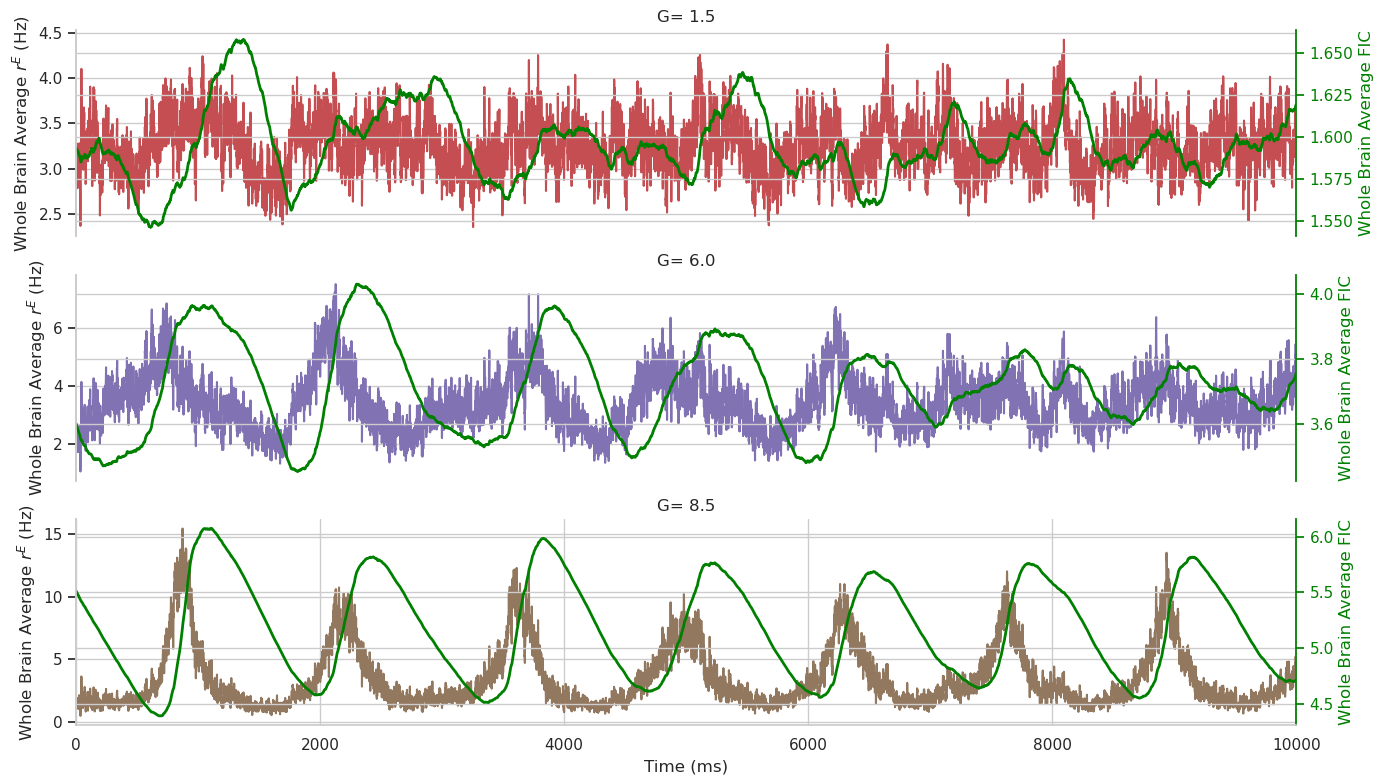

In [49]:
# Plottin timeseries
max_t = 10000
acor_tbase = np.arange(0,max_t)
acor_tbase_s = np.arange(0,max_t)*0.001
figname = 'three_timeseries'
fig, axes = plt.subplots(3, 1, figsize=(14, 8))


for e in range(3):
    ax = axes[e]
    ax.plot(acor_tbase, np.mean(e_rates_tseries[e, :, :max_t], axis=0), color=col_pal[3+e])
    
    # Create a twin Axes for the right y-axis
    ax2 = ax.twinx()
    ax2.plot(acor_tbase, np.mean(fic_tseries[e, :, :max_t], axis=0), color='green', linewidth=2)  # Plot on the right y-axis
    
    ax.set_ylabel(r'Whole Brain Average $r^E$ (Hz)')
    ax2.set_ylabel(r'Whole Brain Average FIC', color='green')
    # Set the color of the ticks and tick labels on the right y-axis
    ax2.yaxis.set_tick_params(color='green', labelcolor='green')    
    # Set the color of the vertical axis line on the right y-axis
    ax2.spines['right'].set_color('green')
    if e==2:
        ax.set_xlabel('Time (ms)')
    else:
        ax.set_xticks([])
    ax.set_title(f'G= {gvals_tseries[e]}')
    plt.xlim([0,max_t])

    ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    # ax2.spines['right'].set_visible(False)
    # ax2.spines['left'].set_visible(False)
    if e<2:
        ax2.spines['bottom'].set_visible(False)    
    

plt.tight_layout()
fig.savefig(figfold+figname+'.png', dpi=300)
fig.savefig(figfold+figname+'.pdf')
plt.show()

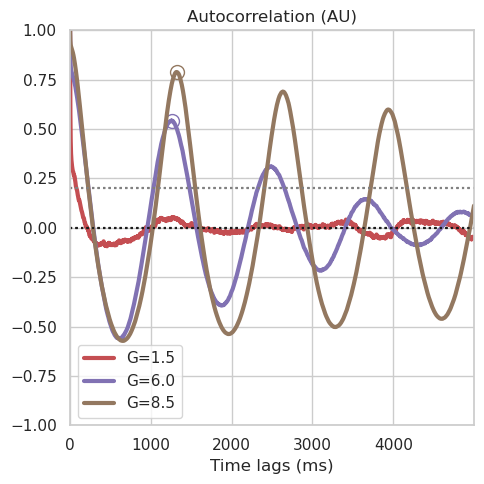

In [54]:
t_len = np.shape(acorrs)[1]
max_t = 5000
acor_tbase = np.arange(0,max_t)
acor_tbase_s = np.arange(0,max_t)*0.001
xcorr_tbase = np.arange(- max_t/2, max_t/2)

# Extacting max of the xcorr
sel_xcorr = np.vstack(([x[int(t_len - max_t/2):int(t_len + max_t/2)] for x in xcorr_rate_fic]))
max_xcorr_id = np.argmax(sel_xcorr, axis=1)
min_xcorr_id = np.argmin(sel_xcorr, axis=1)
# [[[sel_xcorr[x,min_xcorr_id[x]] for x in range(3)], xcorr_tbase[min_xcorr_id]],
# [[sel_xcorr[x,max_xcorr_id[x]] for x in range(3)], xcorr_tbase[max_xcorr_id]]]


pp = list()
figname = 'autocorr_and_cross_corr'
fig = plt.figure(figsize=(10, 5))
for e in range(3):
    plt.subplot(1,2,1)
    plt.plot(acor_tbase, acorrs[e,0:max_t], 
         color=col_pal[3+e], linewidth=3, label='G='+str(gvals_tseries[e]))
    if e>0:
        plt.plot(acorr_time[e],acorr_peak[e],'o',color=col_pal[3+e],
                 markersize=10, fillstyle='none')
    pp.append(auxp)
    plt.ylim([-1,1])
    plt.title('Autocorrelation (AU)')
    plt.xlabel('Time lags (ms)')
    plt.plot([acor_tbase[0],acor_tbase[-1]],[0,0],'k:')
    plt.plot([acor_tbase[0],acor_tbase[-1]],[0.2,0.2],':',color=[0.5,0.5,0.5])
    plt.xlim([acor_tbase[0],acor_tbase[-1]])
    if e==2:
        plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(xcorr_tbase, xcorr_rate_fic[e][int(t_len - max_t/2):int(t_len + max_t/2)], 
             color=col_pal[3+e], linewidth=3)
    plt.plot(xcorr_tbase[max_xcorr_id[e]], sel_xcorr[e,max_xcorr_id[e]],
            'o',color=col_pal[3+e],markersize=10, fillstyle='none')
    plt.plot(xcorr_tbase[min_xcorr_id[e]], sel_xcorr[e,min_xcorr_id[e]],
        'o',color=col_pal[3+e],markersize=10, fillstyle='none')
    plt.ylim([-1,1])
    plt.plot([0,0],[-1,1],'k:')
    plt.plot([xcorr_tbase[0],xcorr_tbase[-1]],[0,0],'k:')
    plt.xlim([xcorr_tbase[0],xcorr_tbase[-1]])
    plt.title('Cross-correlation ($<r^E>_{WB}$,<FIC>) (AU)')
    plt.xlabel('Time lags (ms)')
    



plt.tight_layout()
fig.savefig(figfold+figname+'.png', dpi=300)
fig.savefig(figfold+figname+'.pdf')
plt.show()

In [44]:
t_len = np.shape(acorrs)[1]
max_t = 5000
acor_tbase = np.arange(0,max_t)
acor_tbase_s = np.arange(0,max_t)*0.001
xcorr_tbase = np.arange(- max_t/2, max_t/2)

# Extacting max of the xcorr
sel_xcorr = np.vstack(([x[int(t_len - max_t/2):int(t_len + max_t/2)] for x in xcorr_rate_fic]))
max_xcorr_id = np.argmax(sel_xcorr, axis=1)
min_xcorr_id = np.argmin(sel_xcorr, axis=1)
# [[[sel_xcorr[x,min_xcorr_id[x]] for x in range(3)], xcorr_tbase[min_xcorr_id]],
# [[sel_xcorr[x,max_xcorr_id[x]] for x in range(3)], xcorr_tbase[max_xcorr_id]]]


pp = list()
figname = 'autocorr_and_cross_corr'
fig = plt.figure(figsize=(10, 5))
for e in range(3):
    plt.subplot(1,1,1)
    plt.plot(acor_tbase, acorrs[e,0:max_t], 
         color=col_pal[3+e], linewidth=3, label='G='+str(gvals_tseries[e]))
    if e>0:
        plt.plot(acorr_time[e],acorr_peak[e],'o',color=col_pal[3+e],
                 markersize=10, fillstyle='none')
    pp.append(auxp)
    plt.ylim([-1,1])
    plt.title('Autocorrelation (AU)')
    plt.xlabel('Time lags (ms)')
    plt.plot([acor_tbase[0],acor_tbase[-1]],[0,0],'k:')
    plt.plot([acor_tbase[0],acor_tbase[-1]],[0.2,0.2],':',color=[0.5,0.5,0.5])
    plt.xlim([acor_tbase[0],acor_tbase[-1]])
    if e==2:
        plt.legend()




plt.tight_layout()
plt.show()

NameError: name 'acorrs' is not defined

In [309]:
np.shape(sel_xcorr)
max_xcorr

array([2288, 2216, 2225])

In [ ]:
# Sanity checks
fig = plt.figure(figsize=(14, 10))

# Correlation SC-FC
plt.subplot(2,4,1)
plt.imshow(np.mean(corr_to_sc_grid,axis=0).T,vmin=0, vmax=1,cmap='inferno', 
           interpolation='none',origin='lower', aspect='auto')
plt.yticks(ticks=np.arange(0,nlrs+1,10),labels=np.floor(10*np.logspace(0,3,11))/10)
plt.xticks(ticks=np.arange(0,ngs+1,10), labels=np.linspace(1,G_max,7))
plt.ylabel('Learning Rate')
plt.xlabel('Global Coupling')
plt.colorbar(label='Corr(SC,FC)')


plt.subplot(2,4,2)
plt.imshow(np.mean(corr_to_sc_grid,axis=0).T,vmin=0, vmax=1,cmap='inferno', 
           interpolation='none',origin='lower', aspect='auto')
plt.yticks(ticks=np.arange(0,nlrs+1,10),labels=np.floor(10*np.logspace(0,3,11))/10)
plt.xticks(ticks=np.arange(0,ngs+1,10), labels=np.linspace(1,G_max,7))
plt.ylabel('Learning Rate')
plt.xlabel('Global Coupling')
plt.colorbar(label='Corr(SC,FC)')

In [14]:

from scipy.signal import butter, lfilter
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import os
import math
from helper_functions import filter_bold
#from mne.time_frequency import psd_array_multitaper


def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - params["wsize"] - 1, params["wsize"] - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + params["wsize"] + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
params = dmf.default_params(C=C)
RECEPTORS = np.load("./data/Schaeffer200-Tian/5HT2a_cimbi_hc29_beliveau_schaeffer200.npy")[:200]
RECEPTORS = RECEPTORS/max(RECEPTORS)-min(RECEPTORS)
RECEPTORS = RECEPTORS - max(RECEPTORS) + 1
params["receptors"] = RECEPTORS
# Main setup for this simulation
params["return_rate"] = True
params["return_bold"] = True
params["return_fic"] = True
# These are now default true
params["with_plasticity"] = True
params["with_decay"] = True

isubfcd = np.triu_indices(C.shape[1],1)
burnout = 7
params["flp"] = 0.01
params["fhp"] = 0.1
params["wsize"] = 30
overlap = 29
#nb_steps = 460000
#T = (nb_steps/params["TR"])*params["dtt"]
T = 250
params['TR'] = 2
nb_steps = int((T*params["TR"])/params["dtt"])
win_start = np.arange(0, T - burnout - params["wsize"], params["wsize"] - overlap)
nwins = len(win_start)
nints = len(isubfcd[0])
b_filter,a_filter = butter(2,np.array([0.01, 0.1])*2*params['TR'], btype='band')

# Load coefficients to estimte Decay with LR

fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
triu_idx = np.triu_indices(C.shape[1],1)
params['N'] = C.shape[0]



def_params = dmf.default_params(C=C)

# Main setup for this simulation
def_params["return_rate"] = True
def_params["return_bold"] = False
def_params["return_fic"] = True  # Ensure fic_t is returned
def_params["with_plasticity"] = True
def_params["with_decay"] = True

In [15]:
params

{'C': array([[0.        , 0.08752499, 0.02092163, ..., 0.        , 0.        ,
         0.        ],
        [0.08752499, 0.        , 0.07420782, ..., 0.        , 0.        ,
         0.        ],
        [0.02092163, 0.07420782, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.04535186,
         0.01097723],
        [0.        , 0.        , 0.        , ..., 0.04535186, 0.        ,
         0.06271242],
        [0.        , 0.        , 0.        , ..., 0.01097723, 0.06271242,
         0.        ]]),
 'receptors': array([0.37160159, 0.57847425, 0.62616497, 0.25142087, 0.17000767,
        0.31635092, 0.44400001, 0.35667513, 0.55409915, 0.24211195,
        0.1319321 , 0.23400062, 0.36740884, 0.34150642, 0.1049512 ,
        0.07080406, 0.5141697 , 0.72639799, 0.57667719, 0.36223845,
        0.22099793, 0.32942981, 0.40505849, 0.39581027, 0.68599752,
        0.24249796, 0.26150599, 0.30303085, 0.45898

In [17]:
def_params['flp']

KeyError: 'flp'